# initialisation

In [1]:
import backproject
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import glob
import cv2
import torch
from sklearn.cluster import KMeans
import os

In [2]:
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    print(frames)
    frame_one = frames[0]
    frame_one.save(os.path.join(frame_folder, 'gif.gif'), format="GIF", append_images=frames,
               save_all=True, duration=200, loop=0)

In [3]:
RoomName = "office2"
path_to_traj = f"/home/rozenberszki/project/wsnsl/Datasets/Replica/room0/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)

path_to_traj = f"/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/processedData/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
T_wc[:, 1:3] *= -1

color_paths = sorted(glob.glob(f"/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/*.jpg"))
print(color_paths)
depth_paths = sorted(glob.glob(f"/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/processedData/depth/*.png"))


['/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000000.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000001.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000002.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000003.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000004.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000005.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000006.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000007.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000008.jpg', '/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/rgb/frame_000009.jpg', '/home/ro

In [4]:
'''
for i in range(20):
    color_path = color_paths[i*50]
    color_data = cv2.imread(color_path)
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    images.append(image)
    masksarr.append(masks)
del sam
'''


'\nfor i in range(20):\n    color_path = color_paths[i*50]\n    color_data = cv2.imread(color_path)\n    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)\n    masks = mask_generator.generate(image)\n    images.append(image)\n    masksarr.append(masks)\ndel sam\n'

In [5]:
import vis
import matplotlib.pyplot as plt
'''
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.imshow(images[i])
    vis.show_anns(masksarr[i])
    plt.axis('off')
    plt.show() 
    '''
def visualizerForAuto(image, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.axis('off')
    plt.show() 
def visualizerWithPrompts(image,masks,prompts):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.scatter(prompts[0,:],prompts[1,:],c='r',s=10)
    plt.axis('off')
    plt.show()

In [6]:
images=[]
masksarr=[]

K = np.eye(3)
K[0, 0] = 1430.2189
K[1, 1] = 1430.2266
K[0, 2] = 954.92126
K[1, 2] = 724.7766

# Helper

In [7]:

def readDepth(filepath):
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    return depth_data


def checkIfInsideImage(backprojectedSamples, zg, Depthg, border, H,W):
    backprojectedSamples = backprojectedSamples.astype(int)
    # efficient
    # filter out samples outside of image bounds
    condition = (
        (backprojectedSamples[1, :] < 0 + border)
        | (backprojectedSamples[0, :] < 0 + border)
        | (backprojectedSamples[1, :] > H -1 - border)
        | (backprojectedSamples[0, :] > W -1 - border)
    )
    filteredIndices = np.where(condition)
    filteredBackProj = backprojectedSamples[:, ~condition]

    depthg = np.array(Depthg[filteredBackProj[1, :], filteredBackProj[0, :]])
    zg = np.delete(zg, filteredIndices)
    depthCheck = depthg - zg
    # print(f'depthCkeck, smaller 0.005: {np.count_nonzero(abs(depthCheck) < 0.005)}, depthCheck, smaller 0.01: {np.count_nonzero(abs(depthCheck) < 0.01)}, smaller 0.1: {np.count_nonzero(abs(depthCheck) < 0.1)}')
    print("depthCheck",depthCheck)
    indices = np.where(abs(depthCheck) < 1)
    filteredBackProj = filteredBackProj[:, indices]
    return filteredBackProj

def generateIds(masks, min_area=1000):
    """sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ids = np.ones(
        (
            sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1],
            1,
        )
    )
    # maybe more efficient
    # first frame has 85 instances so not too bad
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        idsForEachMask = np.concatenate([[i]])
        ids[m] = idsForEachMask
    return ids.squeeze().astype(np.int32)"""
    sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    if min_area > 0:
        sortedMasks = [mask for mask in sortedMasks if mask["area"] > min_area]
    ids = np.full(
            (sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1]),
            -100,
        )
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        ids[m] = i
    unique_ids,counts = np.unique(ids, return_counts=True)
    for i in range(len(unique_ids)):
        if counts[i] < min_area:
            ids[ids == unique_ids[i]] = -100
    return ids

def sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1):
    tensors = []

    temp=np.unique(ids)[1:]
    for i,element in enumerate(list(temp.astype(int))):
        if element >=0:            
            labels = np.where(ids == element)
            indices = list(zip(labels[0], labels[1]))
            points_per_instance= np.sum(ids == element)
            #points_per_instance=int(2*np.log2(points_per_instance))
            points_per_instance=2*points_per_instance//(60*60)
            if len(indices) > points_per_instance and len(indices)>1 and points_per_instance>1:  # Check if there are any True pixels
                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)
                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T
                element_tensor = torch.full((sampled_tensor.shape[1],), element)
                
                element_tensor = element_tensor.unsqueeze(0)
                
                tensors.append(torch.cat((sampled_tensor, element_tensor), axis=0))

    torch_sampled_indices = torch.cat(tensors, axis=1)
    return torch_sampled_indices.to(torch.int32)

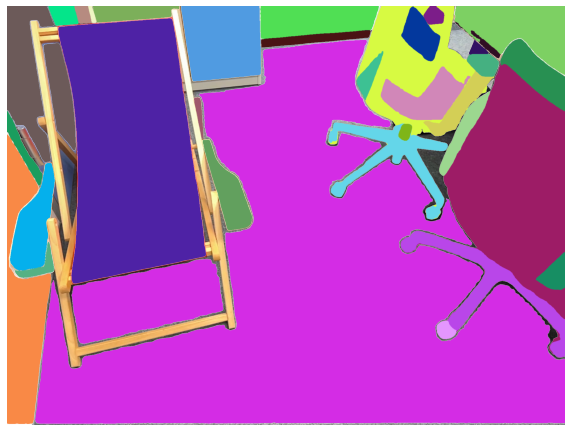

In [8]:
sam_checkpoint = '/home/rozenberszki/project/wsnsl/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")


mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
#crop_n_layers (int): If >0, mask prediction will be run again on
#crops of the image. Sets the number of layers to run, where each
 #layer has 2**i_layer number of image crops.
 #crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
"""

  mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
currFramenumber=0
color_data = cv2.imread(color_paths[currFramenumber])
image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
ids = generateIds(masks, min_area=1000)
#idler sortlancak
plt.figure(figsize=(10,10))
plt.imshow(image)
vis.show_anns(masks)
plt.axis('off')
plt.show()

# Code

In [11]:

def createFrontMappingAutosort(
    curr_frame_number,
    T,
    K,
    depths,
    automaticMask,
    max_id=None,
    current_frame=None,
    samples=None,
    smallesMaskSize=10000,
    border=25,
    verbose=False,
):
    visualizerForId=vis.visualizerForIds()
    
    if curr_frame_number==0:
        masks = automaticMask.generate(current_frame)
        ids = generateIds(masks, min_area=smallesMaskSize)
        #idler sortlancak
        '''if verbose:
            plt.figure(figsize=(10,10))
            plt.imshow(current_frame)
            vis.show_anns(masks)
            plt.axis('off')
            #plt.savefig(os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{0}_mask_{curr_frame_number}_{-1}.png'))
            plt.show()'''
        max_id = ids.max()+1
        samplesFromCurrent = sample_from_instances_with_ids_area(
            ids, max_id, points_per_instance=1000
        )
        if verbose:
            visualizerForId.visualizer(anns=ids, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet".zfill(6), prompts=samplesFromCurrent[:, samplesFromCurrent[2, :] == 0])

        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            T_wc[0],
            K,
            readDepth(depth_paths[0]),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        
        print("First iter unique",len(np.unique(ids)))
        visualizerForId.visualizer(anns=ids, path = None)

        return ids, realWorldSamples, max_id


    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)

    T_current = T[curr_frame_number]
    depthf = readDepth(depths[curr_frame_number])
    
    frontProjectedSamples, projDepth = backproject.camProject(samples, T_current, K)
    if verbose:
        print("Before Checkinside")
        visualizerForId.visualizer(anns=ids, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet", prompts=frontProjectedSamples[:, frontProjectedSamples[2, :] == 0])
      
    frontProjectedSamples = checkIfInsideImage(
        frontProjectedSamples, projDepth, depthf, border=border, H=depthf.shape[0], W=depthf.shape[1]
    )
    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)
   
    if frontProjectedSamples.ndim == 3:
        frontProjectedSamples = frontProjectedSamples.reshape(3, -1)

    if verbose:
        visualizerForId.visualizer(anns=ids, path = None)
    
    """ 
    # Projected everything onto the current frame
    # Now for each sample project on to the image and check if it is inside the each mask instance
    # on to the each currentMask take majority of the samples and assign to the mask
    # some are pruned do not take the max_id into account
    """
    copyOfIds = np.full(ids.shape, -100)
    for currentMaskId in current_unique_ids:
        if currentMaskId < 0:
            continue
        currentMask= ids == currentMaskId
        dictOfIds = {-100: -100}
        for instance in np.unique(frontProjectedSamples[2, :]):
            if instance >= 0:
                samplesInside= frontProjectedSamples[:, frontProjectedSamples[2, :] == instance]
                insideTheMask= currentMask[samplesInside[1, :] , samplesInside[0, :]]
                dictOfIds[instance] = np.sum(insideTheMask)
                
        maxForMask= max(dictOfIds, key=dictOfIds.get)
        if maxForMask != -100 and dictOfIds[maxForMask] > 0.4 * np.sum(insideTheMask):
            copyOfIds[ids==currentMaskId ] = maxForMask
        elif maxForMask != -100:
            copyOfIds[ ids==currentMaskId ] = max_id
            max_id += 1
            print("CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN")
        if verbose:
            visualizerForId.visualizer(anns=copyOfIds, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet", prompts=frontProjectedSamples[:, frontProjectedSamples[2, :] == 0])
        print("The Found Projection instance",maxForMask)
        print("Mapping",dictOfIds)
        print("MaxId",max_id)
        
    ids=copyOfIds
    
    if border != 0:
        ids[0 : 2 * border] = -100
        ids[-2 * border :] = -100
        ids[:, 0 : 2 * border] = -100
        ids[:, -2 * border :] = -100
    
    numberOfMasks = len(np.unique(ids))

    # TODO sample according to the areas of the masks
    samplesFromCurrent = sample_from_instances_with_ids_area(
        ids, numberOfMasks, points_per_instance=100
    )
    # 3d
    realWorldProjectCurr = backproject.realWorldProject(
        samplesFromCurrent[:2, :], T[curr_frame_number], K, depthf
    )
    # add the ids
    realWorldProjectCurr = np.concatenate(
        (realWorldProjectCurr, samplesFromCurrent[2:, :]), axis=0
    )
    samples = np.concatenate((samples, realWorldProjectCurr), axis=1)
    #max_id = np.max(samples[2:, :])
    #print(samples)
    print("Current unique ids", current_unique_ids)
    if not verbose:
        visualizerForId.visualizer(anns=copyOfIds, path = f"/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet/{str(curr_frame_number).zfill(6)}" )
    
    return ids, samples, max_id


'''
            visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{currentMaskId}_mask_{curr_frame_number}_{most_common_instance}.png'), prompts = frontProjectedSamples[:2, filter_most_common])
            '''      

First iter unique 34


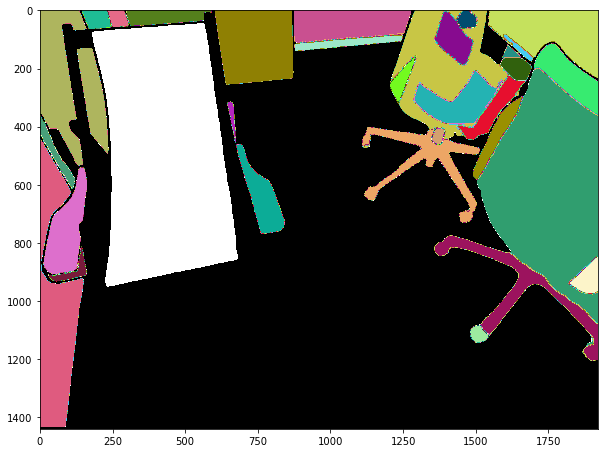

depthCheck [ 0.01762319  0.00832543  0.00650873 ...  0.15449407  0.08914745
 -0.04579954]
The Found Projection instance 0
Mapping {-100: -100, 0: 700, 1: 0, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0}
MaxId 33
The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 189, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0}
MaxId 33
The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 115, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 13, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0}
MaxId 33
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 28, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1,

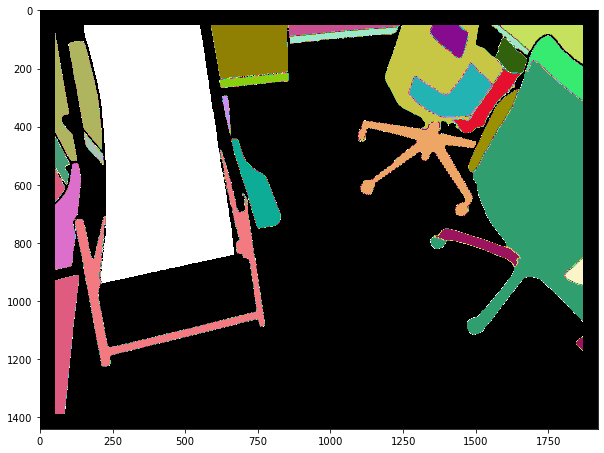

depthCheck [ 0.09563557  0.03916376  0.0365613  ... -0.03610723 -0.01173397
 -0.11273677]
The Found Projection instance 0
Mapping {-100: -100, 0: 1355, 1: 0, 2: 0, 3: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 2, 10: 2, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 26: 0, 33: 2, 34: 0}
MaxId 37
The Found Projection instance 1
Mapping {-100: -100, 0: 2, 1: 377, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 26: 0, 33: 1, 34: 0}
MaxId 37
The Found Projection instance 2
Mapping {-100: -100, 0: 1, 1: 0, 2: 231, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 13, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 26: 0, 33: 0, 34: 0}
MaxId 37
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 39, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 2, 11: 0, 12: 0, 13: 5, 14: 0, 15: 0, 16: 0, 17: 8, 19: 2, 20: 0, 21: 0, 22: 0, 23: 0

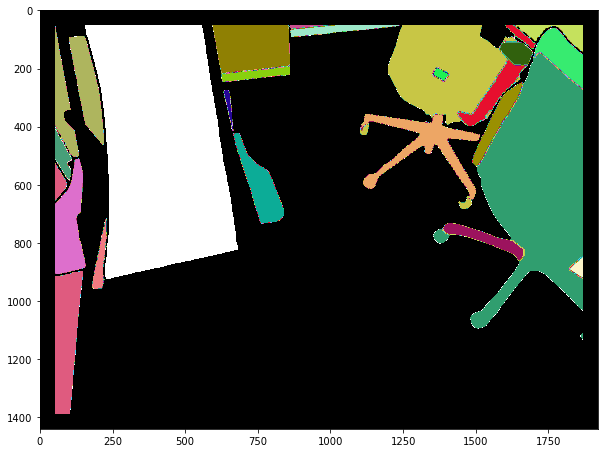

depthCheck [ 0.20975144  0.15451299  0.13296038 ...  0.07633209 -0.02324416
 -0.21278088]
The Found Projection instance 0
Mapping {-100: -100, 0: 2040, 1: 0, 2: 1, 3: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 2, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 1, 22: 0, 23: 0, 24: 0, 26: 0, 33: 0, 34: 0}
MaxId 39
The Found Projection instance 1
Mapping {-100: -100, 0: 2, 1: 554, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 26: 0, 33: 1, 34: 0}
MaxId 39
The Found Projection instance 2
Mapping {-100: -100, 0: 1, 1: 0, 2: 300, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 13, 10: 0, 11: 0, 12: 0, 13: 0, 14: 2, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 26: 0, 33: 0, 34: 0}
MaxId 39
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 73, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 6, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 1, 26: 0, 33: 0, 34: 0

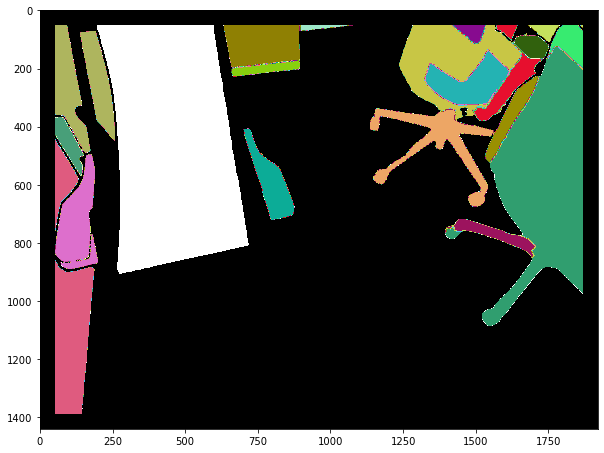

depthCheck [ 0.23892517  0.19632304  0.17211162 ...  0.03385388  0.02509403
 -0.03633995]
The Found Projection instance 0
Mapping {-100: -100, 0: 2728, 1: 0, 2: 3, 3: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 2, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 2, 17: 0, 19: 1, 20: 3, 22: 0, 23: 0, 24: 1, 25: 0, 26: 0, 33: 0, 34: 0}
MaxId 39
The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 739, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 33: 2, 34: 0}
MaxId 39
The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 326, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 4, 15: 0, 16: 0, 17: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 33: 0, 34: 0}
MaxId 39
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 108, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 56, 11: 0, 12: 0, 13: 10, 14: 0, 15: 27, 16: 0, 17: 4, 19: 2, 20: 0, 22: 0, 23: 5, 24

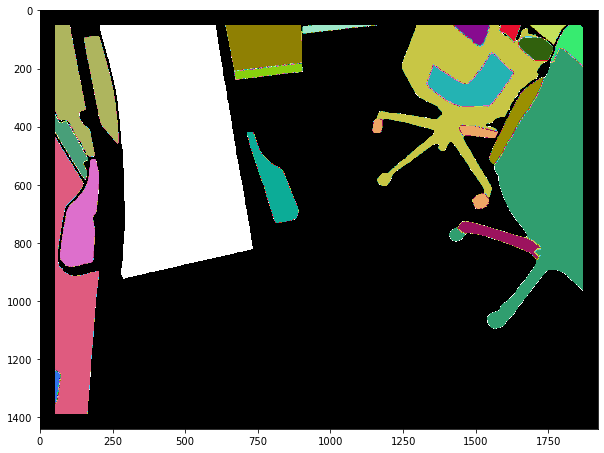

depthCheck [ 0.0311935   0.01550653  0.02031283 ... -0.04161876 -0.03125613
 -0.36744255]
The Found Projection instance 0
Mapping {-100: -100, 0: 3276, 1: 0, 2: 5, 3: 4, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 3, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0}
MaxId 40
The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 941, 2: 0, 3: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 1, 26: 0, 27: 1, 33: 1, 34: 0}
MaxId 40
The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 413, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 28, 10: 0, 11: 0, 12: 0, 13: 0, 14: 4, 15: 0, 16: 0, 17: 0, 18: 0, 19: 4, 20: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0}
MaxId 40
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 156, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 2, 11: 0, 12: 0, 13: 10, 14: 0, 15: 23, 16

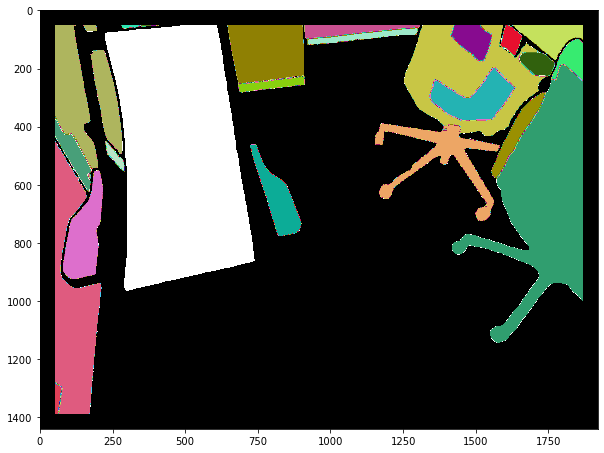

depthCheck [-0.02243068 -0.02453853 -0.01423015 ...  0.00921311  0.06934606
 -0.28765998]
The Found Projection instance 0
Mapping {-100: -100, 0: 3451, 1: 0, 2: 2, 3: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 5, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 1}
MaxId 43
The Found Projection instance 1
Mapping {-100: -100, 0: 3, 1: 1135, 2: 0, 3: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 33: 1, 34: 0}
MaxId 43
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 151, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 6, 11: 0, 12: 0, 13: 11, 14: 0, 15: 29, 16: 0, 17: 6, 18: 0, 19: 2, 20: 0, 22: 0, 23: 3, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0}
MaxId 43
The Found Projection instance 5
Mapping {-100: -100, 0: 2, 1: 0, 2: 0, 3: 0, 5: 188, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16

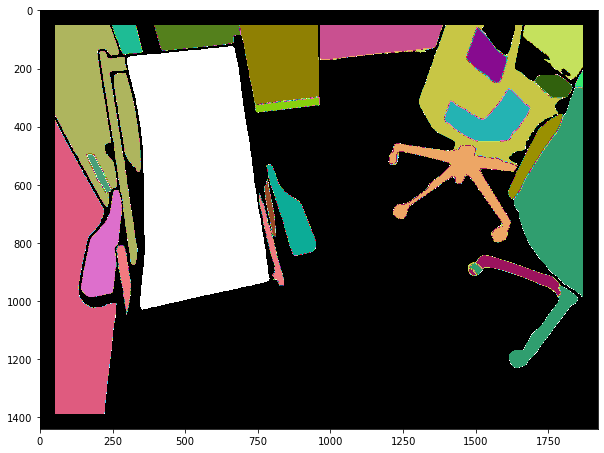

depthCheck [-0.0795783  -0.07617949 -0.05275734 ... -0.75401863 -0.04064468
 -0.08796302]
The Found Projection instance 0
Mapping {-100: -100, 0: 3444, 1: 0, 2: 30, 3: 15, 5: 0, 6: 0, 7: 0, 8: 0, 9: 11, 10: 21, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 3, 17: 0, 18: 0, 19: 8, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 11, 34: 0, 43: 0}
MaxId 44
The Found Projection instance 1
Mapping {-100: -100, 0: 32, 1: 1240, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 4, 34: 0, 43: 0}
MaxId 44
The Found Projection instance 3
Mapping {-100: -100, 0: 2, 1: 0, 2: 1, 3: 179, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0, 10: 5, 11: 0, 12: 0, 13: 24, 14: 0, 15: 25, 16: 0, 17: 14, 18: 0, 19: 16, 20: 2, 22: 0, 23: 0, 24: 1, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0, 43: 0}
MaxId 44
The Found Projection instance 5
Mapping {-100: -100, 0: 16, 1: 0, 2: 0, 3: 0, 5: 239, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 

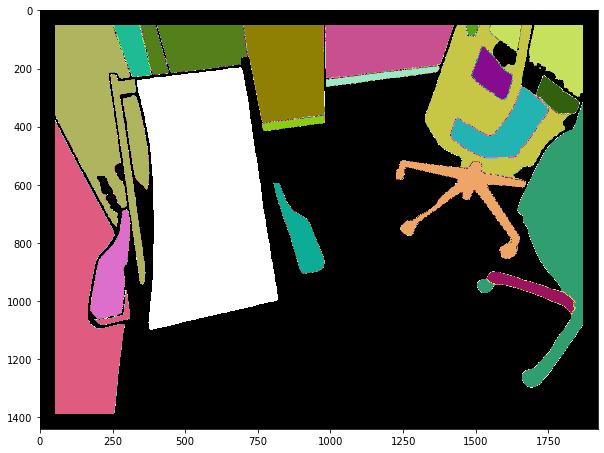

depthCheck [-0.03833012 -0.02768884 -0.01258864 ... -0.10804218  0.02877266
 -0.05735946]
The Found Projection instance 0
Mapping {-100: -100, 0: 3513, 1: 0, 2: 57, 3: 22, 5: 0, 6: 0, 7: 0, 8: 0, 9: 21, 10: 43, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 11, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 14, 34: 0, 43: 0}
MaxId 45
The Found Projection instance 1
Mapping {-100: -100, 0: 59, 1: 1376, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 6, 34: 0, 43: 0}
MaxId 45
The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 523, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 2, 10: 0, 11: 0, 12: 0, 13: 0, 14: 5, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0, 43: 0}
MaxId 45
The Found Projection instance 3
Mapping {-100: -100, 0: 8, 1: 0, 2: 3, 3: 191, 5: 0, 6: 0, 7: 0, 8: 5, 9: 0, 10: 11, 11: 0, 12:

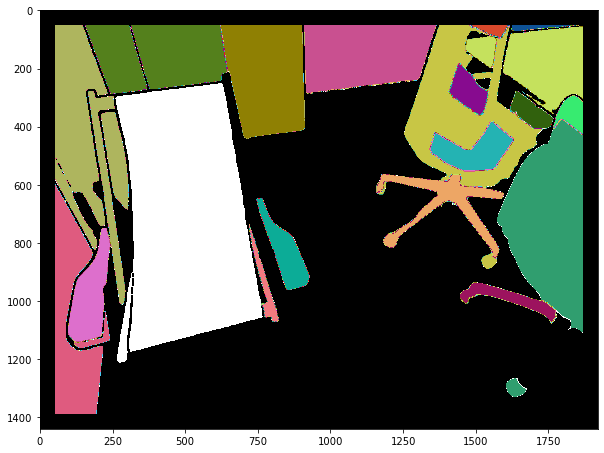

depthCheck [-0.10295906 -0.04353053 -0.03701281 ...  0.01015436 -0.06818272
 -0.08157076]
The Found Projection instance 0
Mapping {-100: -100, 0: 4104, 1: 0, 2: 41, 3: 17, 5: 0, 6: 0, 7: 0, 8: 0, 9: 14, 10: 37, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 9, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 14, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 1
Mapping {-100: -100, 0: 60, 1: 1582, 2: 0, 3: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 6, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 2
Mapping {-100: -100, 0: 2, 1: 0, 2: 606, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 5, 10: 0, 11: 0, 12: 0, 13: 0, 14: 4, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 3, 3: 181, 5: 0, 6: 0, 7: 0, 8: 6, 9: 0

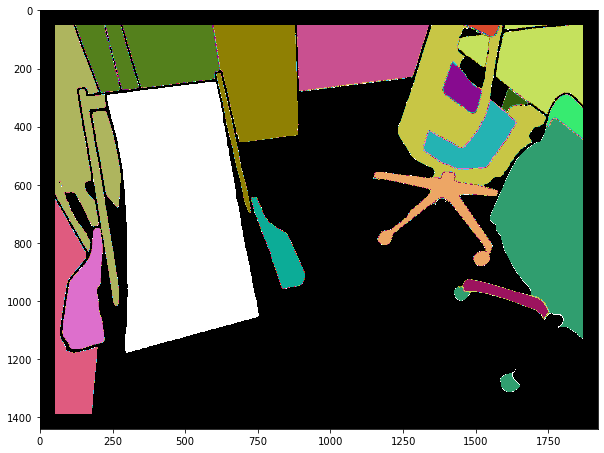

depthCheck [-0.08568333 -0.06723743 -0.04970358 ...  0.54418464 -0.20570962
  0.2694155 ]
The Found Projection instance 0
Mapping {-100: -100, 0: 3944, 1: 0, 2: 31, 3: 18, 5: 0, 6: 0, 7: 0, 8: 0, 9: 12, 10: 34, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 10, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 5, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 1
Mapping {-100: -100, 0: 68, 1: 1792, 2: 0, 3: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 6, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 2
Mapping {-100: -100, 0: 50, 1: 0, 2: 804, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 12, 10: 0, 11: 0, 12: 0, 13: 0, 14: 4, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0, 43: 0, 46: 0}
MaxId 47
The Found Projection instance 7
Mapping {-100: -100, 0: 3, 1: 0, 2: 0, 3: 0, 5: 0, 6: 0, 7: 299, 8: 0, 9:

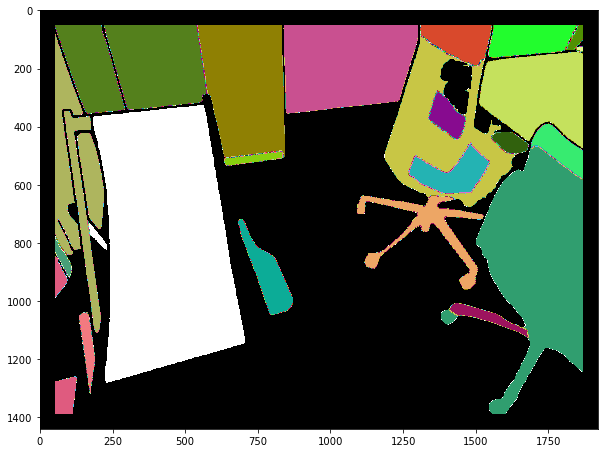

depthCheck [-0.11344518 -0.0301516   0.01729597 ... -0.16906605 -0.12639099
  0.17610932]
The Found Projection instance 0
Mapping {-100: -100, 0: 2958, 1: 0, 2: 49, 3: 28, 5: 0, 6: 0, 7: 0, 8: 0, 9: 20, 10: 56, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 2, 17: 0, 18: 0, 19: 13, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 0, 43: 0, 46: 0, 47: 0}
MaxId 50
The Found Projection instance 1
Mapping {-100: -100, 0: 83, 1: 1899, 2: 0, 3: 0, 5: 0, 6: 0, 7: 5, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 6, 34: 0, 43: 0, 46: 0, 47: 0}
MaxId 50
The Found Projection instance 7
Mapping {-100: -100, 0: 9, 1: 17, 2: 0, 3: 0, 5: 0, 6: 0, 7: 351, 8: 0, 9: 0, 10: 0, 11: 18, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 150, 19: 0, 20: 3, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 33: 0, 34: 12, 43: 0, 46: 0, 47: 0}
MaxId 50
The Found Projection instance 11
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 6, 5: 

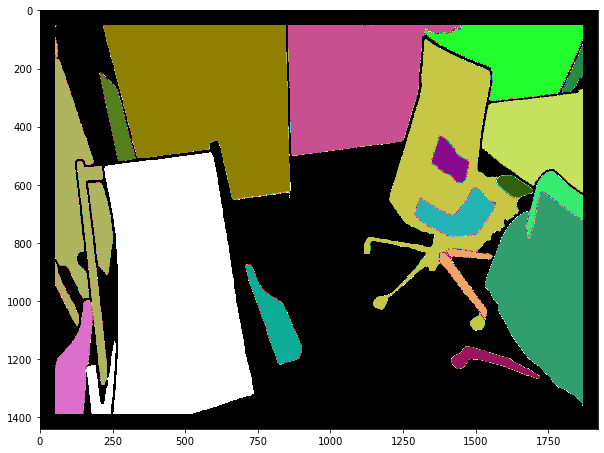

depthCheck [-0.09890133 -0.06052064  0.00545472 ... -0.0565312   0.03244722
  0.07014482]
The Found Projection instance 7
Mapping {-100: -100, 0: 18, 1: 33, 2: 0, 3: 0, 5: 0, 6: 0, 7: 526, 8: 0, 9: 0, 10: 0, 11: 8, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 153, 19: 0, 20: 2, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 33: 0, 34: 18, 43: 0, 46: 0, 47: 0, 51: 0}
MaxId 53
The Found Projection instance 0
Mapping {-100: -100, 0: 2062, 1: 0, 2: 8, 3: 28, 5: 0, 6: 0, 7: 0, 8: 0, 9: 4, 10: 71, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 9, 17: 0, 18: 0, 19: 13, 20: 2, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 33: 0, 34: 0, 43: 0, 46: 0, 47: 0, 51: 0}
MaxId 53
The Found Projection instance 11
Mapping {-100: -100, 0: 6, 1: 0, 2: 0, 3: 9, 5: 0, 6: 0, 7: 0, 8: 5, 9: 0, 10: 0, 11: 346, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 14, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 33: 0, 34: 0, 43: 0, 46: 1, 47: 63, 51: 0}
MaxId 53
The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 1540, 2: 0, 3: 0, 5:

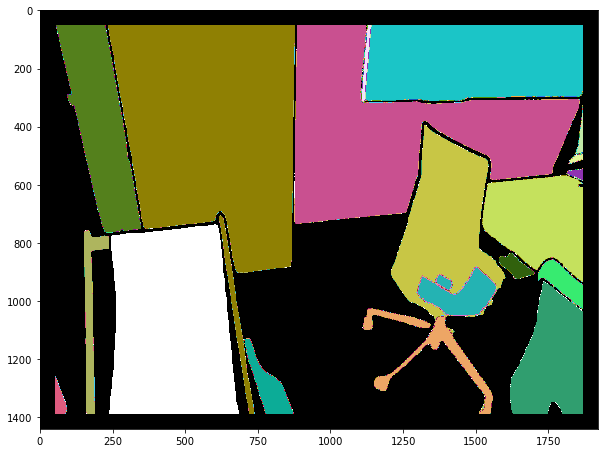

depthCheck [-0.14263409 -0.09052463 -0.02961325 ...  0.0199014  -0.01025008
 -0.00769795]
The Found Projection instance 7
Mapping {-100: -100, 0: 47, 1: 69, 2: 0, 3: 0, 6: 0, 7: 741, 8: 0, 10: 0, 11: 36, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 149, 19: 0, 20: 3, 22: 0, 23: 0, 25: 0, 27: 0, 33: 0, 34: 17, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0}
MaxId 59
The Found Projection instance 11
Mapping {-100: -100, 0: 24, 1: 0, 2: 0, 3: 14, 6: 0, 7: 0, 8: 8, 10: 0, 11: 497, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 18, 22: 0, 23: 0, 25: 0, 27: 0, 33: 0, 34: 0, 46: 1, 47: 61, 51: 1, 53: 0, 56: 1}
MaxId 59
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 18, 2: 0, 3: 0, 6: 390, 7: 0, 8: 0, 10: 0, 11: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 4, 19: 0, 20: 0, 22: 0, 23: 0, 25: 5, 27: 0, 33: 0, 34: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0}
MaxId 59
The Found Projection instance 0
Mapping {-100: -100, 0: 1141, 1: 0, 2: 0, 3: 23, 6: 0, 7: 0, 8: 0, 10: 39, 11: 0, 13: 0, 14: 0, 15: 0, 16: 

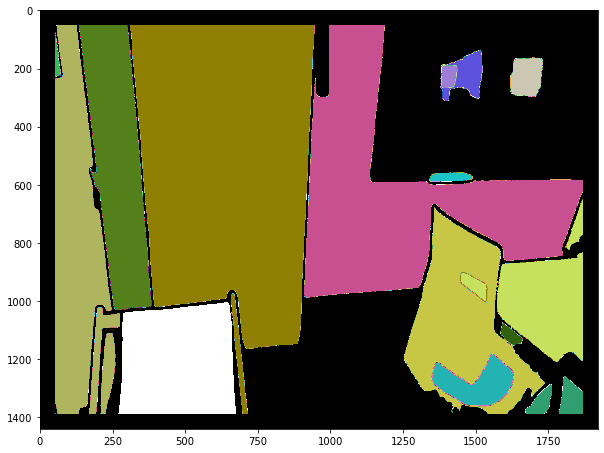

depthCheck [-1.19785761e-01 -8.33753371e-02 -2.93172630e-02 ... -6.28413412e-03
  2.53517164e-05 -1.39194733e-03]
The Found Projection instance 7
Mapping {-100: -100, 0: 80, 1: 111, 2: 0, 3: 0, 6: 0, 7: 1057, 8: 0, 11: 55, 13: 0, 14: 0, 15: 0, 17: 0, 18: 143, 20: 3, 23: 0, 25: 0, 27: 0, 34: 17, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 63
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 6: 0, 7: 0, 8: 0, 11: 15, 13: 0, 14: 0, 15: 0, 17: 0, 18: 0, 20: 0, 23: 0, 25: 0, 27: 0, 34: 0, 46: 0, 47: 0, 51: 0, 53: 105, 56: 0, 59: 7, 61: 1, 62: 2}
MaxId 63
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 2, 2: 0, 3: 0, 6: 380, 7: 0, 8: 0, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 18: 11, 20: 0, 23: 0, 25: 6, 27: 0, 34: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 63
The Found Projection instance 18
Mapping {-100: -100, 0: 0, 1: 32, 2: 0, 3: 0, 6: 1, 7: 15, 8: 0, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 18: 207, 20: 0, 23: 0, 25

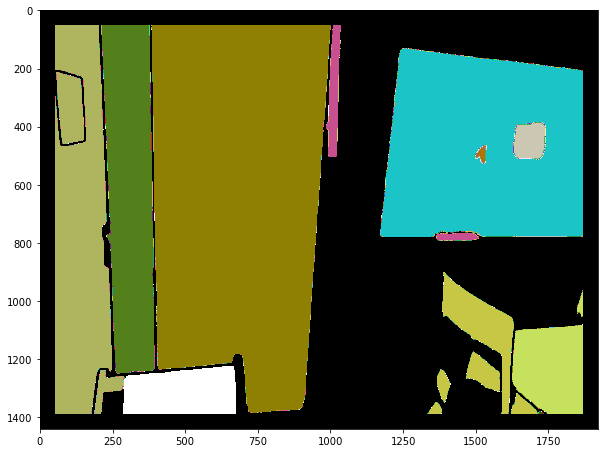

depthCheck [-0.12540694 -0.08661074 -0.03195778 ... -0.00501532 -0.00616562
 -0.00589937]
The Found Projection instance 11
Mapping {-100: -100, 0: 108, 1: 0, 3: 31, 6: 0, 7: 0, 8: 25, 11: 626, 15: 0, 17: 0, 18: 0, 20: 19, 25: 0, 27: 0, 46: 1, 47: 54, 51: 3, 53: 8, 56: 2, 59: 0, 61: 0, 62: 0}
MaxId 64
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 1: 0, 3: 0, 6: 0, 7: 0, 8: 0, 11: 34, 15: 0, 17: 0, 18: 0, 20: 0, 25: 0, 27: 0, 46: 0, 47: 7, 51: 0, 53: 311, 56: 0, 59: 4, 61: 5, 62: 2}
MaxId 64
The Found Projection instance 7
Mapping {-100: -100, 0: 0, 1: 104, 3: 0, 6: 0, 7: 628, 8: 0, 11: 0, 15: 0, 17: 0, 18: 140, 20: 0, 25: 0, 27: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 64
The Found Projection instance 7
Mapping {-100: -100, 0: 12, 1: 0, 3: 0, 6: 0, 7: 668, 8: 0, 11: 81, 15: 0, 17: 0, 18: 0, 20: 4, 25: 0, 27: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 64
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 8, 3: 0, 6: 3

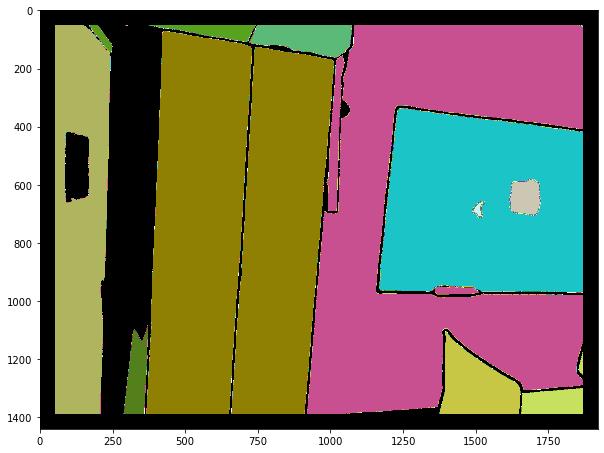

depthCheck [-0.17705014 -0.17108473 -0.28085941 ...  0.6529324   0.65676539
  0.71228851]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 0, 7: 2, 8: 0, 11: 290, 18: 128, 25: 1, 46: 0, 47: 0, 51: 0, 53: 8, 56: 2, 59: 0, 61: 0, 62: 0, 64: 1, 65: 6}
MaxId 69
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 6: 0, 7: 1332, 8: 0, 11: 73, 18: 107, 25: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0}
MaxId 69
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 6: 0, 7: 0, 8: 0, 11: 40, 18: 0, 25: 0, 46: 0, 47: 8, 51: 0, 53: 514, 56: 0, 59: 6, 61: 7, 62: 1, 64: 0, 65: 0}
MaxId 69
The Found Projection instance 11
Mapping {-100: -100, 3: 14, 6: 0, 7: 0, 8: 3, 11: 490, 18: 0, 25: 0, 46: 1, 47: 33, 51: 1, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0}
MaxId 69
The Found Projection instance 6
Mapping {-100: -100, 3: 0, 6: 282, 7: 0, 8: 0, 11: 0, 18: 42, 25: 5, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0}
MaxId 69
CH

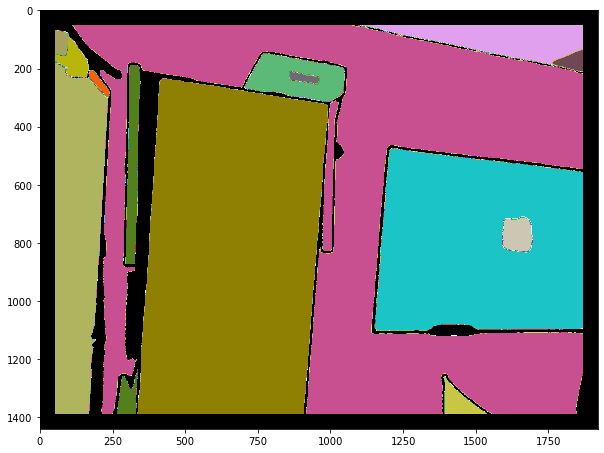

depthCheck [-0.05259932 -0.05203105 -0.05586457 ...  0.61584964  0.04050879
 -0.07075759]
The Found Projection instance 11
Mapping {-100: -100, 3: 10, 6: 0, 7: 30, 8: 3, 11: 899, 18: 100, 46: 1, 47: 37, 51: 1, 53: 33, 56: 2, 59: 0, 61: 0, 62: 0, 64: 4, 65: 6, 69: 0, 70: 0, 71: 0}
MaxId 76
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 6: 0, 7: 1280, 8: 0, 11: 55, 18: 5, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 0, 70: 0, 71: 0}
MaxId 76
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 6: 0, 7: 0, 8: 1, 11: 82, 18: 0, 46: 0, 47: 15, 51: 0, 53: 698, 56: 0, 59: 5, 61: 10, 62: 2, 64: 0, 65: 0, 69: 0, 70: 0, 71: 0}
MaxId 76
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 0, 7: 0, 8: 0, 11: 4, 18: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 1, 70: 0, 71: 0}
MaxId 76
The Found Projection instance 6
Mapping {-100: -100, 3: 0, 6: 114, 7: 0, 8: 0, 11: 0, 18: 37, 46: 0, 47: 0, 51: 0, 53: 0, 56: 

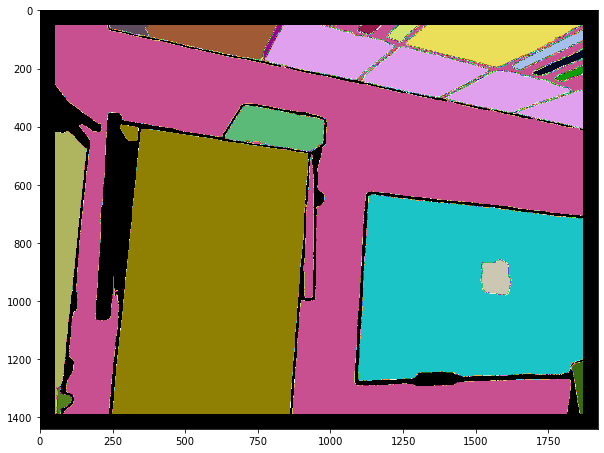

depthCheck [-0.03755931  0.49287572 -0.02683852 ... -0.01058037  0.01297692
 -0.00491134]
The Found Projection instance 11
Mapping {-100: -100, 3: 1, 6: 0, 7: 10, 8: 0, 11: 1020, 18: 1, 47: 16, 51: 0, 53: 44, 56: 2, 59: 0, 61: 0, 62: 0, 64: 8, 65: 6, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0}
MaxId 87
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 6: 0, 7: 1381, 8: 0, 11: 38, 18: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0}
MaxId 87
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 0, 7: 0, 8: 0, 11: 10, 18: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 10, 71: 0, 76: 1, 77: 0, 78: 0, 79: 2, 80: 0, 81: 1, 82: 0}
MaxId 87
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 6: 0, 7: 0, 8: 1, 11: 99, 18: 0, 47: 18, 51: 0, 53: 930, 56: 0, 59: 6, 61: 12, 62: 2, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 1, 79: 0, 80: 0, 81: 0, 82

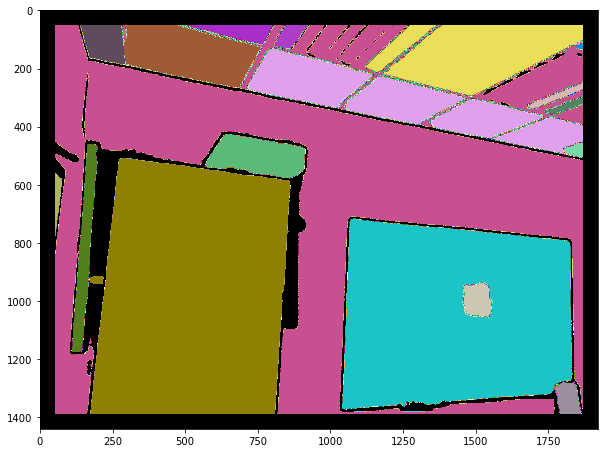

depthCheck [-0.03420911 -0.02069803 -0.02453672 ...  0.01269441 -0.04602163
  0.02963795]
The Found Projection instance 11
Mapping {-100: -100, 3: 1, 7: 17, 8: 0, 11: 1301, 18: 0, 47: 13, 51: 0, 53: 56, 56: 2, 59: 0, 61: 0, 62: 0, 64: 17, 65: 6, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 87: 0, 88: 0, 89: 0, 90: 0}
MaxId 94
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 0, 8: 0, 11: 31, 18: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 8, 71: 0, 76: 1, 77: 4, 78: 0, 79: 0, 80: 1, 81: 1, 82: 0, 87: 0, 88: 0, 89: 2, 90: 0}
MaxId 94
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 1547, 8: 0, 11: 29, 18: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 87: 0, 88: 0, 89: 0, 90: 0}
MaxId 94
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 7: 0, 8: 1, 11: 102, 18: 0, 47: 20, 51: 1, 53: 1147, 56: 0, 59: 7, 61: 14, 62: 2, 64: 0, 65:

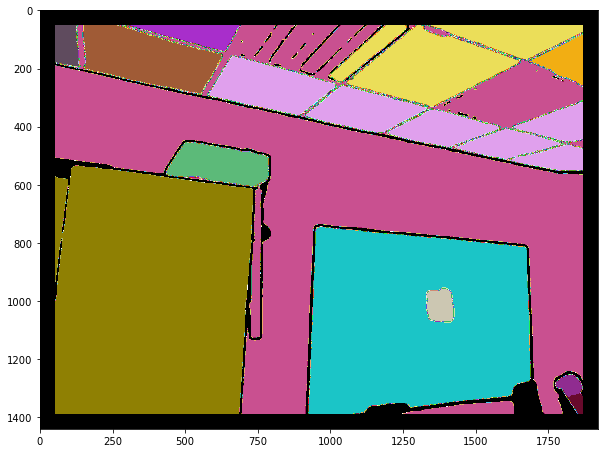

depthCheck [-0.22345842 -0.28093855 -0.16966046 ...  0.01582824  0.11409767
 -0.47110344]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 22, 8: 0, 11: 1490, 47: 0, 51: 0, 53: 56, 56: 2, 59: 0, 61: 0, 62: 0, 64: 18, 65: 4, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 81: 0, 82: 0, 87: 0, 88: 1, 89: 0, 90: 0, 94: 0, 96: 0}
MaxId 97
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 0, 8: 0, 11: 45, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 9, 71: 0, 76: 6, 77: 2, 78: 0, 79: 2, 81: 1, 82: 0, 87: 2, 88: 0, 89: 0, 90: 0, 94: 1, 96: 0}
MaxId 97
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 1173, 8: 0, 11: 13, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 81: 0, 82: 0, 87: 0, 88: 0, 89: 0, 90: 0, 94: 0, 96: 0}
MaxId 97
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 7: 0, 8: 1, 11: 105, 47: 19, 51: 1, 53: 1377, 56: 0, 59: 6, 61: 40, 62: 2, 64: 0, 65: 0, 69: 

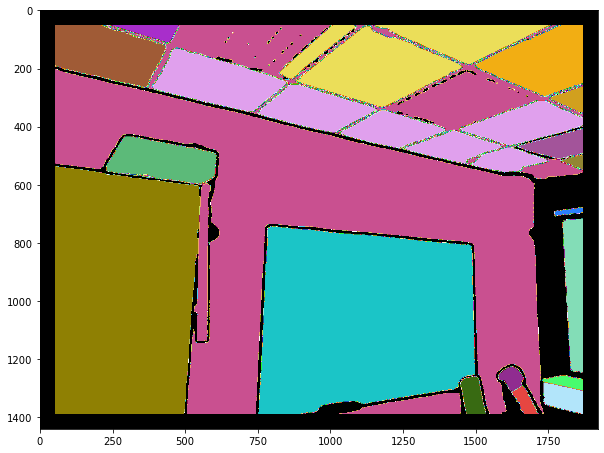

depthCheck [ 0.03477317 -0.04786174  0.0127029  ...  0.10462775  0.03795731
 -0.01552136]
The Found Projection instance 11
Mapping {-100: -100, 3: 8, 7: 39, 8: 5, 11: 1876, 46: 1, 47: 38, 51: 1, 53: 88, 56: 1, 59: 0, 61: 0, 62: 0, 64: 23, 69: 0, 71: 0, 76: 0, 77: 0, 78: 1, 79: 0, 81: 0, 82: 0, 88: 3, 90: 0, 94: 0, 96: 0, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0}
MaxId 105
The Found Projection instance 76
Mapping {-100: -100, 3: 0, 7: 0, 8: 0, 11: 59, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 48, 71: 0, 76: 172, 77: 0, 78: 0, 79: 2, 81: 1, 82: 0, 88: 0, 90: 0, 94: 1, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0}
MaxId 105
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 7: 0, 8: 1, 11: 157, 46: 0, 47: 22, 51: 1, 53: 1458, 56: 0, 59: 2, 61: 24, 62: 0, 64: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 1, 79: 0, 81: 0, 82: 0, 88: 0, 90: 0, 94: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0}
MaxId 105
The Found Projection instance 7
Mapping {-100: -1

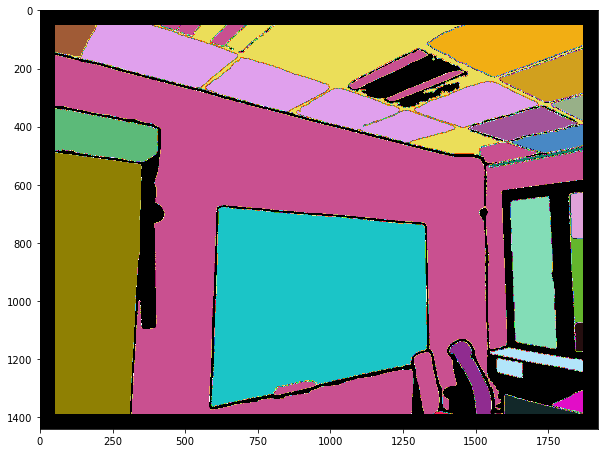

depthCheck [ 1.91875459  1.8365437   1.99057119 ... -0.05315089  0.26721262
  0.04839968]
The Found Projection instance 11
Mapping {-100: -100, 3: 18, 7: 102, 8: 15, 11: 2437, 46: 1, 47: 43, 51: 1, 53: 68, 56: 0, 59: 0, 61: 0, 62: 0, 64: 24, 69: 2, 71: 0, 76: 2, 77: 0, 78: 3, 79: 0, 81: 0, 82: 0, 88: 3, 90: 0, 94: 0, 96: 1, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0}
MaxId 114
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 0, 8: 0, 11: 27, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 21, 71: 0, 76: 17, 77: 1, 78: 0, 79: 0, 81: 0, 82: 0, 88: 0, 90: 0, 94: 4, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 1, 110: 0, 112: 0}
MaxId 114
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 7: 0, 8: 0, 11: 175, 46: 0, 47: 18, 51: 0, 53: 1788, 56: 1, 59: 6, 61: 27, 62: 1, 64: 0, 69: 0, 71: 0, 76: 0, 77: 0, 78: 0, 79: 0, 81: 0, 82: 0, 88: 0, 90: 0, 94: 

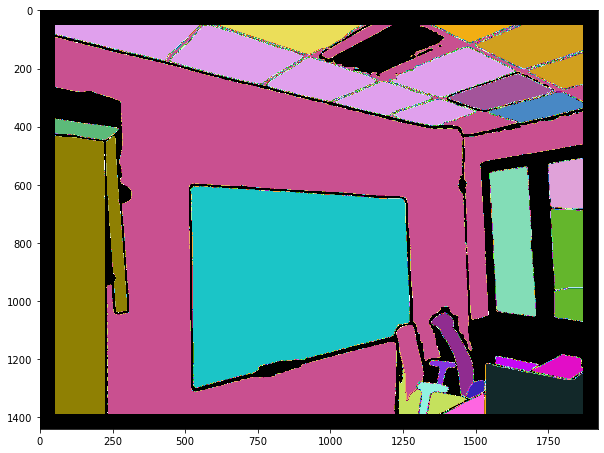

depthCheck [ 2.15387721  2.28462316  0.50221437 ... -0.24570913 -1.87613035
 -0.04203372]
The Found Projection instance 11
Mapping {-100: -100, 3: 32, 7: 186, 8: 16, 11: 2813, 46: 1, 47: 42, 51: 0, 53: 115, 56: 0, 59: 0, 61: 0, 62: 0, 64: 34, 69: 0, 71: 0, 76: 0, 78: 4, 88: 4, 96: 2, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0}
MaxId 119
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 7: 0, 8: 0, 11: 239, 46: 0, 47: 18, 51: 0, 53: 1973, 56: 2, 59: 7, 61: 33, 62: 2, 64: 0, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0}
MaxId 119
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 748, 8: 0, 11: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 2, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 

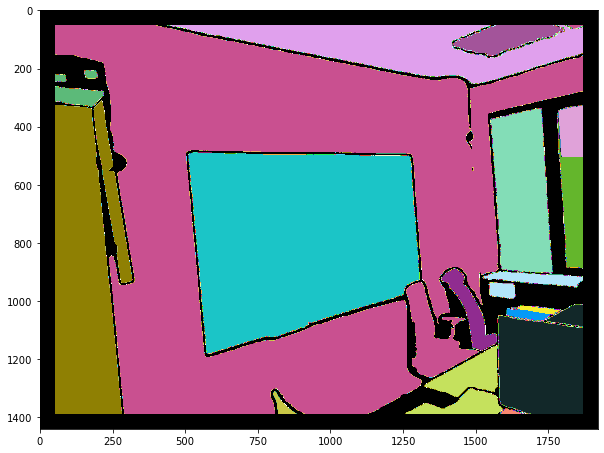

depthCheck [-0.22351108  1.72366251 -0.2140267  ... -0.01852228  0.0510313
 -0.01348655]
The Found Projection instance 11
Mapping {-100: -100, 0: 39, 3: 37, 7: 204, 8: 20, 11: 3509, 14: 0, 15: 0, 17: 0, 20: 10, 23: 0, 46: 1, 47: 48, 51: 0, 53: 70, 56: 0, 59: 0, 61: 0, 62: 0, 64: 32, 69: 18, 76: 0, 78: 0, 88: 3, 96: 1, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0}
MaxId 122
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 3: 1, 7: 0, 8: 0, 11: 198, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 14, 51: 0, 53: 2205, 56: 2, 59: 5, 61: 25, 62: 2, 64: 0, 69: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0}
MaxId 122
The Found Projection instance 7
Mapping {-100: -100, 0: 0, 3: 0, 7: 976, 8: 0, 11: 0, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 8, 69: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 

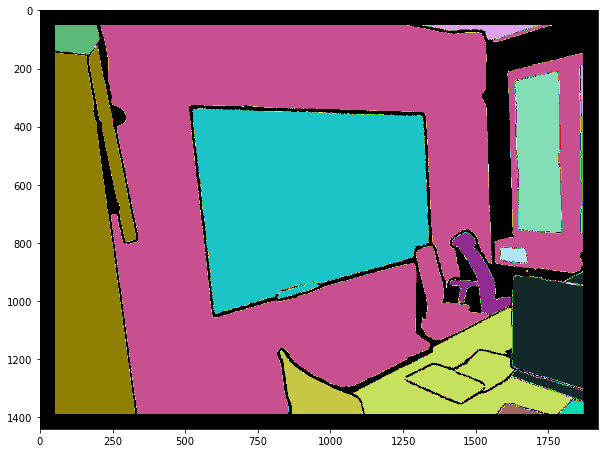

depthCheck [-0.22826529 -0.18508021 -0.1327137  ... -0.02167866  0.00363774
 -0.00638892]
The Found Projection instance 11
Mapping {-100: -100, 0: 99, 2: 0, 3: 39, 7: 231, 8: 20, 11: 3529, 13: 0, 14: 0, 15: 0, 17: 0, 20: 19, 23: 0, 46: 2, 47: 48, 51: 0, 53: 59, 56: 0, 59: 0, 61: 0, 62: 0, 64: 7, 69: 0, 76: 0, 78: 0, 88: 3, 96: 1, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0}
MaxId 124
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 1, 7: 0, 8: 0, 11: 236, 13: 0, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 14, 51: 0, 53: 2510, 56: 2, 59: 6, 61: 23, 62: 1, 64: 0, 69: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0}
MaxId 124
The Found Projection instance 7
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 7: 914, 8: 0, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 0, 76: 

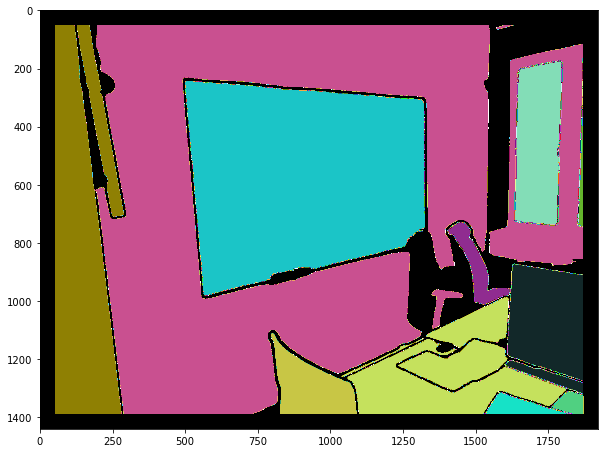

depthCheck [-0.26761784 -0.22167129 -0.16606355 ... -0.04147718 -0.04033442
 -0.03812149]
The Found Projection instance 11
Mapping {-100: -100, 0: 191, 2: 0, 3: 43, 7: 226, 8: 23, 11: 3481, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 26, 23: 0, 24: 0, 46: 1, 47: 47, 51: 2, 53: 48, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 2, 96: 2, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 1, 108: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0}
MaxId 126
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 1, 7: 0, 8: 0, 11: 261, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 46: 0, 47: 15, 51: 0, 53: 2715, 56: 2, 59: 5, 61: 15, 62: 1, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0}
MaxId 126
The Found Projection instance 7
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 7: 1009, 8: 0, 11: 2, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 

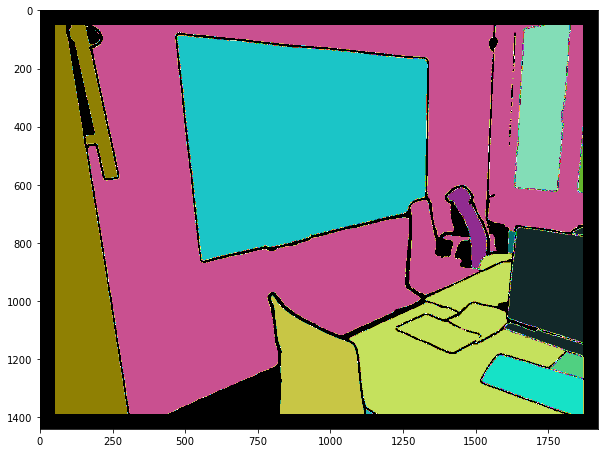

depthCheck [-0.28706305 -0.2493646  -0.19244651 ...  0.01662662 -0.03618747
 -0.02871781]
The Found Projection instance 11
Mapping {-100: -100, 0: 188, 2: 0, 3: 42, 7: 208, 8: 28, 11: 2801, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 26, 23: 0, 24: 0, 34: 0, 46: 4, 47: 47, 51: 3, 53: 39, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0}
MaxId 127
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 7: 0, 8: 0, 11: 196, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 34: 0, 46: 0, 47: 14, 51: 0, 53: 2881, 56: 1, 59: 4, 61: 11, 62: 1, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0}
MaxId 127
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 99, 3: 63, 7: 0, 8: 414, 11: 0, 13: 6, 14: 83, 15: 8, 17: 0, 19: 5, 20: 1, 23: 51, 24: 0, 34: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 

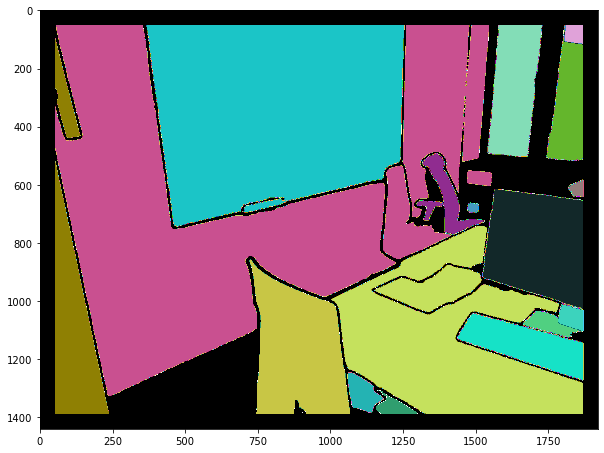

depthCheck [-0.31901902 -0.27126118 -0.21753838 ...  0.11269315  0.04098159
 -0.0365549 ]
The Found Projection instance 11
Mapping {-100: -100, 0: 185, 2: 0, 3: 57, 7: 12, 8: 41, 10: 0, 11: 2254, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 26, 23: 0, 24: 0, 34: 0, 46: 2, 47: 48, 51: 3, 53: 86, 56: 1, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0}
MaxId 130
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 1, 7: 0, 8: 0, 10: 0, 11: 135, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 34: 0, 46: 0, 47: 11, 51: 0, 53: 2490, 56: 0, 59: 2, 61: 13, 62: 1, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0}
MaxId 130
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 90, 3: 31, 7: 0, 8: 501, 10: 0, 11: 0, 13: 0, 14: 83, 15: 6, 17: 0, 19: 2, 20: 1, 23: 45, 24: 0, 34: 0, 46: 0, 47: 0

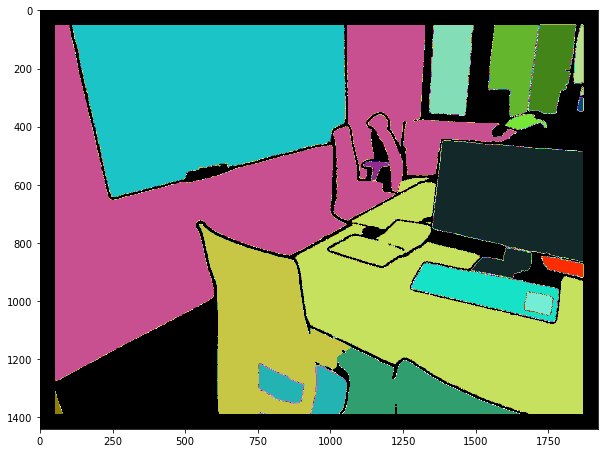

depthCheck [-0.35779161 -0.33396629 -0.27805952 ... -0.03908806 -1.32683488
 -3.68219174]
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 80, 3: 29, 8: 667, 10: 0, 11: 0, 13: 0, 14: 83, 15: 6, 17: 0, 19: 3, 20: 1, 21: 0, 23: 43, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 61: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 23, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 15, 125: 3, 127: 1, 132: 0, 133: 0}
MaxId 137
The Found Projection instance 11
Mapping {-100: -100, 0: 95, 2: 0, 3: 48, 8: 43, 10: 0, 11: 1277, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 9, 21: 0, 23: 0, 24: 0, 46: 4, 47: 50, 51: 3, 53: 51, 61: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0}
MaxId 137
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 0, 10: 0, 11: 46, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 21: 0, 23: 0, 24: 0, 46: 0, 47: 8, 51: 0, 53: 1427, 61: 3, 78: 0, 88

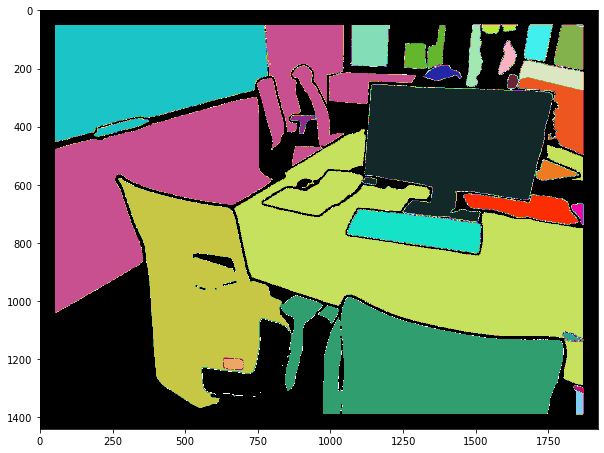

depthCheck [ 0.07788014  0.05189835  0.0441106  ...  0.07721609  0.05020925
 -0.00800394]
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 55, 3: 13, 8: 844, 9: 0, 10: 0, 11: 1, 13: 0, 14: 81, 15: 2, 17: 0, 19: 0, 20: 1, 21: 0, 23: 40, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 78: 0, 88: 0, 96: 0, 99: 0, 106: 17, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 33, 125: 1, 127: 0, 132: 3, 133: 1, 137: 0, 145: 0}
MaxId 152
The Found Projection instance 0
Mapping {-100: -100, 0: 1149, 2: 56, 3: 41, 8: 0, 9: 24, 10: 79, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 19: 1, 20: 0, 21: 0, 23: 0, 24: 1, 46: 0, 47: 0, 51: 0, 53: 0, 78: 0, 88: 0, 96: 0, 99: 0, 106: 0, 110: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 137: 0, 145: 0}
MaxId 152
The Found Projection instance 2
Mapping {-100: -100, 0: 307, 2: 946, 3: 0, 8: 43, 9: 40, 10: 0, 11: 0, 13: 0, 14: 2, 15: 0, 17: 0, 19: 0, 20: 0, 21: 6, 23: 0, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 78: 0, 88: 0, 96: 0, 99: 0, 106: 0, 110: 

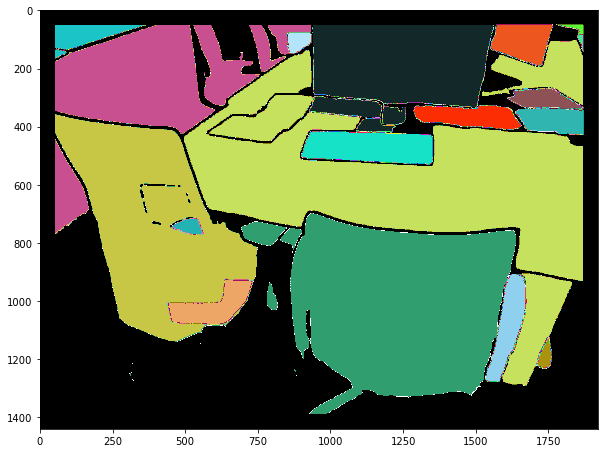

depthCheck [ 0.02849616  0.01522157 -0.96572298 ...  0.15668158  0.14039373
  0.10780627]
The Found Projection instance 0
Mapping {-100: -100, 0: 2029, 2: 99, 3: 31, 8: 2, 9: 44, 10: 84, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 19: 5, 20: 0, 21: 0, 23: 0, 24: 0, 46: 0, 47: 0, 51: 0, 78: 0, 96: 0, 106: 0, 114: 0, 115: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 145: 0, 152: 1, 153: 0, 155: 0}
MaxId 158
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 38, 3: 5, 8: 989, 9: 0, 10: 0, 11: 3, 13: 0, 14: 64, 15: 2, 17: 0, 19: 0, 20: 1, 21: 0, 23: 22, 24: 0, 46: 0, 47: 0, 51: 0, 78: 0, 96: 0, 106: 25, 114: 0, 115: 0, 124: 83, 125: 0, 127: 0, 132: 18, 133: 2, 145: 0, 152: 0, 153: 2, 155: 0}
MaxId 158
The Found Projection instance 2
Mapping {-100: -100, 0: 164, 2: 1135, 3: 0, 8: 126, 9: 32, 10: 0, 11: 0, 13: 0, 14: 17, 15: 0, 17: 0, 19: 0, 20: 0, 21: 6, 23: 0, 24: 0, 46: 0, 47: 0, 51: 0, 78: 0, 96: 0, 106: 0, 114: 0, 115: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 145: 0, 152: 0, 153: 0, 1

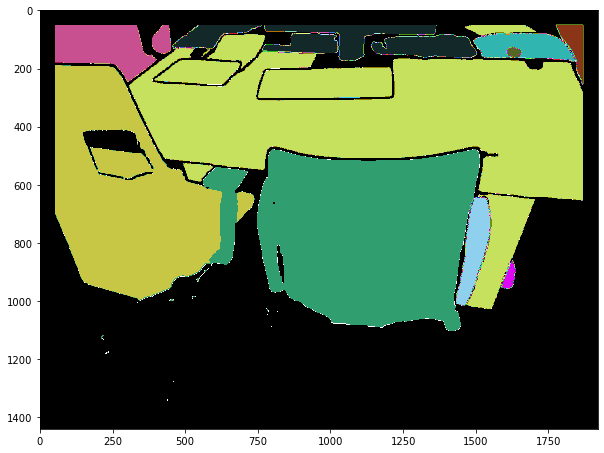

depthCheck [-0.67328107 -0.29023561 -0.03950836 ...  1.98012093  1.8850403
  1.31720933]
The Found Projection instance 0
Mapping {-100: -100, 0: 2099, 2: 120, 3: 13, 8: 3, 9: 43, 10: 58, 11: 0, 13: 0, 14: 0, 15: 0, 17: 0, 19: 6, 20: 0, 21: 0, 23: 0, 47: 0, 51: 0, 96: 0, 106: 0, 114: 0, 115: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 145: 0, 152: 1, 153: 0, 155: 0}
MaxId 161
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 37, 3: 6, 8: 1223, 9: 0, 10: 0, 11: 2, 13: 0, 14: 64, 15: 2, 17: 0, 19: 0, 20: 1, 21: 0, 23: 22, 47: 0, 51: 0, 96: 0, 106: 21, 114: 0, 115: 0, 124: 83, 125: 0, 127: 0, 132: 17, 133: 2, 145: 0, 152: 0, 153: 2, 155: 0}
MaxId 161
The Found Projection instance 2
Mapping {-100: -100, 0: 149, 2: 1329, 3: 0, 8: 160, 9: 29, 10: 0, 11: 0, 13: 0, 14: 19, 15: 0, 17: 0, 19: 0, 20: 0, 21: 6, 23: 0, 47: 0, 51: 0, 96: 0, 106: 0, 114: 0, 115: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 145: 0, 152: 0, 153: 0, 155: 0}
MaxId 161
The Found Projection instance 0
Mapping {-100

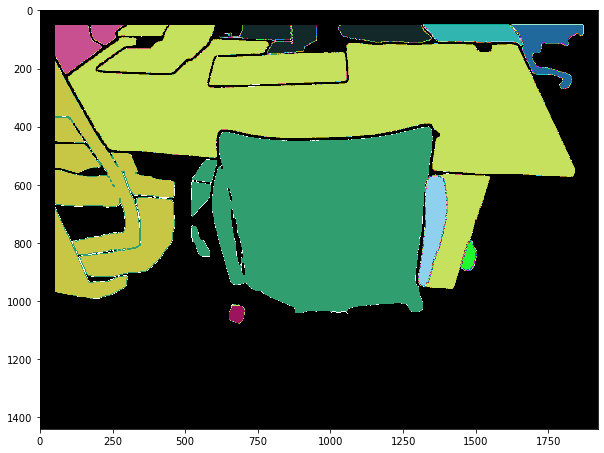

depthCheck [-0.00199059 -0.02190213 -0.2076389  ...  0.07342744 -0.01612601
 -0.00181447]
The Found Projection instance 0
Mapping {-100: -100, 0: 2574, 2: 110, 3: 11, 8: 13, 9: 47, 10: 34, 11: 0, 13: 0, 14: 0, 15: 0, 19: 9, 20: 0, 21: 0, 23: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152: 4, 153: 0, 161: 1}
MaxId 163
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 11, 3: 0, 8: 1049, 9: 0, 10: 0, 11: 0, 13: 0, 14: 46, 15: 0, 19: 0, 20: 0, 21: 0, 23: 1, 106: 8, 124: 111, 125: 2, 127: 0, 132: 21, 133: 3, 152: 0, 153: 6, 161: 0}
MaxId 163
The Found Projection instance 2
Mapping {-100: -100, 0: 109, 2: 1430, 3: 0, 8: 50, 9: 28, 10: 0, 11: 0, 13: 0, 14: 0, 15: 0, 19: 0, 20: 0, 21: 6, 23: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152: 0, 153: 0, 161: 0}
MaxId 163
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 84, 3: 0, 8: 213, 9: 0, 10: 0, 11: 0, 13: 0, 14: 30, 15: 0, 19: 0, 20: 0, 21: 0, 23: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152:

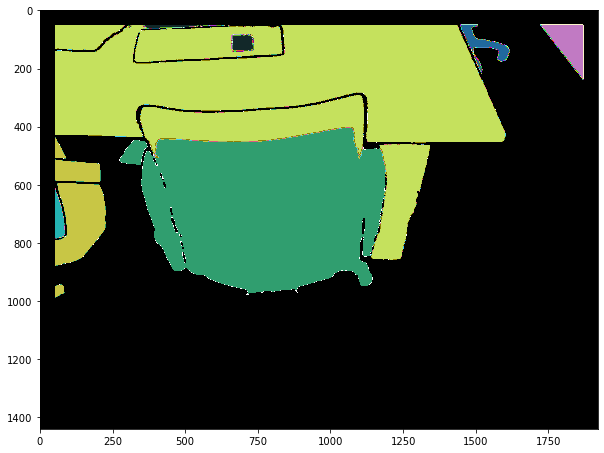

depthCheck [-0.03532937 -0.02923574 -0.48599268 ... -0.4010319  -0.27655805
 -0.40291992]
The Found Projection instance 0
Mapping {-100: -100, 0: 2562, 2: 135, 3: 10, 8: 36, 9: 57, 10: 19, 13: 1, 14: 0, 19: 12, 21: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152: 4, 153: 0, 155: 0, 161: 1, 163: 0}
MaxId 164
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 13, 3: 0, 8: 817, 9: 0, 10: 0, 13: 0, 14: 0, 19: 0, 21: 0, 106: 12, 124: 123, 125: 5, 127: 0, 132: 24, 133: 3, 152: 0, 153: 12, 155: 0, 161: 0, 163: 0}
MaxId 164
The Found Projection instance 2
Mapping {-100: -100, 0: 78, 2: 1488, 3: 0, 8: 90, 9: 27, 10: 0, 13: 0, 14: 1, 19: 0, 21: 6, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152: 0, 153: 0, 155: 0, 161: 0, 163: 0}
MaxId 164
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 0, 9: 0, 10: 0, 13: 0, 14: 0, 19: 0, 21: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 152: 0, 153: 0, 155: 0, 161: 0, 163: 8}
MaxId 164
The Found Projection

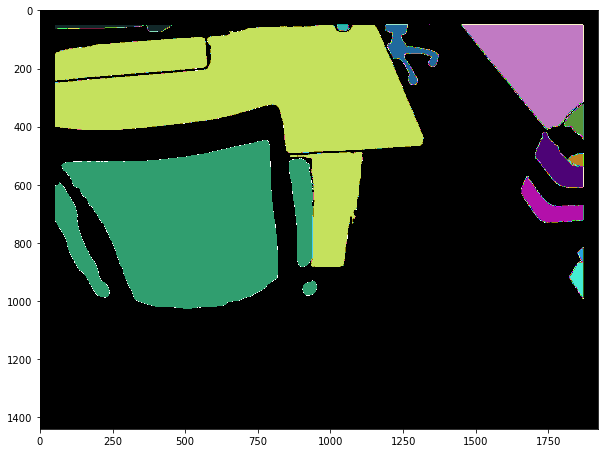

depthCheck [-0.64321597 -0.57181155 -0.024908   ... -0.08366402 -0.32683172
 -0.16320481]
The Found Projection instance 0
Mapping {-100: -100, 0: 1882, 2: 74, 8: 58, 9: 8, 21: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 137: 0, 145: 0, 152: 4, 153: 0, 155: 0, 158: 0, 161: 5, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0}
MaxId 170
The Found Projection instance 2
Mapping {-100: -100, 0: 101, 2: 1360, 8: 197, 9: 30, 21: 6, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 137: 0, 145: 0, 152: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0}
MaxId 170
The Found Projection instance 8
Mapping {-100: -100, 0: 1, 2: 25, 8: 834, 9: 0, 21: 0, 106: 20, 124: 69, 125: 4, 127: 0, 132: 27, 133: 3, 137: 0, 145: 0, 152: 0, 153: 12, 155: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0}
MaxId 170
The Found Projection instance 163
Mapping {-100: -100, 0: 1, 2: 0, 8: 0, 9: 0, 21: 0, 106: 0, 124: 0, 125: 0, 127: 0, 132: 0, 133: 0, 137: 0, 145: 0, 152: 0, 153: 0, 155: 0, 15

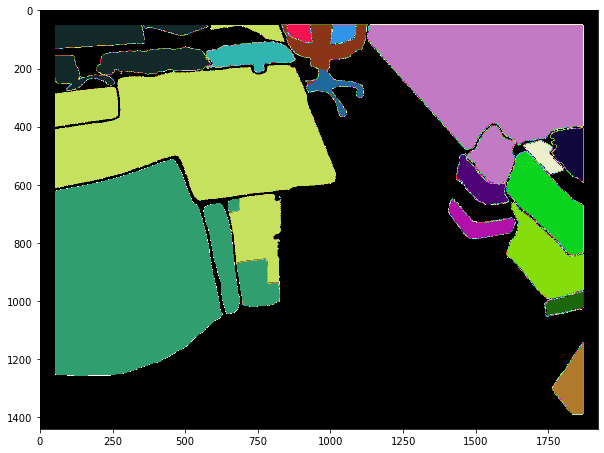

depthCheck [-0.68523798 -0.64101831 -0.61076318 ... -0.55558883 -0.68378387
 -0.61883017]
The Found Projection instance 0
Mapping {-100: -100, 0: 1586, 2: 38, 8: 88, 9: 0, 21: 0, 106: 0, 124: 0, 132: 0, 133: 0, 137: 0, 145: 0, 152: 7, 153: 0, 155: 0, 158: 0, 161: 11, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0}
MaxId 179
The Found Projection instance 163
Mapping {-100: -100, 0: 27, 2: 0, 8: 0, 9: 0, 21: 0, 106: 0, 124: 0, 132: 0, 133: 0, 137: 0, 145: 0, 152: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 188, 164: 0, 165: 0, 166: 1, 167: 0, 170: 0, 171: 0, 172: 0, 173: 1, 174: 0, 175: 0, 176: 0, 177: 0}
MaxId 179
The Found Projection instance 8
Mapping {-100: -100, 0: 2, 2: 40, 8: 848, 9: 0, 21: 0, 106: 11, 124: 19, 132: 25, 133: 3, 137: 0, 145: 0, 152: 0, 153: 5, 155: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0}
MaxId 179
The Found Projection instance 2
Map

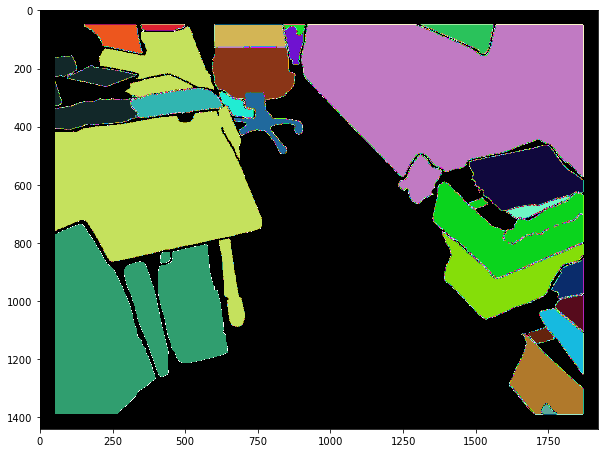

depthCheck [ 0.17699395 -0.11944115 -0.12191231 ...  0.01863617 -1.24948599
  0.08433502]
The Found Projection instance 163
Mapping {-100: -100, 0: 49, 2: 0, 8: 0, 21: 0, 106: 0, 132: 0, 137: 0, 138: 0, 139: 0, 145: 0, 152: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 402, 164: 0, 165: 0, 166: 1, 167: 0, 170: 0, 171: 2, 172: 0, 173: 6, 174: 0, 175: 1, 176: 0, 177: 0, 179: 0, 180: 3, 181: 0, 182: 5, 183: 1, 184: 0, 186: 0, 187: 0}
MaxId 191
The Found Projection instance 0
Mapping {-100: -100, 0: 1314, 2: 4, 8: 113, 21: 0, 106: 0, 132: 0, 137: 0, 138: 0, 139: 0, 145: 0, 152: 9, 153: 0, 155: 0, 158: 1, 161: 17, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0}
MaxId 191
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 50, 8: 728, 21: 0, 106: 0, 132: 14, 137: 0, 138: 0, 139: 0, 145: 0, 152: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 1

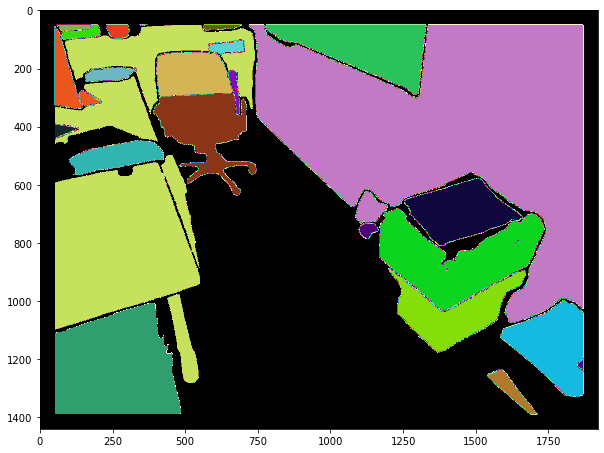

depthCheck [ 3.55869824  3.55630606  0.19130495 ... -0.01147659 -0.27802888
 -0.30838846]
The Found Projection instance 163
Mapping {-100: -100, 0: 70, 2: 0, 8: 0, 106: 0, 132: 0, 137: 0, 152: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 742, 164: 0, 165: 0, 166: 1, 167: 0, 170: 1, 171: 4, 172: 0, 173: 14, 174: 0, 175: 1, 176: 0, 177: 0, 179: 0, 180: 5, 181: 4, 182: 5, 183: 1, 184: 1, 186: 0, 187: 0, 192: 0, 193: 0, 195: 0}
MaxId 199
The Found Projection instance 0
Mapping {-100: -100, 0: 1250, 2: 0, 8: 118, 106: 0, 132: 0, 137: 0, 152: 1, 153: 0, 155: 0, 158: 3, 161: 17, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0, 192: 0, 193: 0, 195: 0}
MaxId 199
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 2: 20, 8: 470, 106: 0, 132: 6, 137: 0, 152: 1, 153: 0, 155: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0

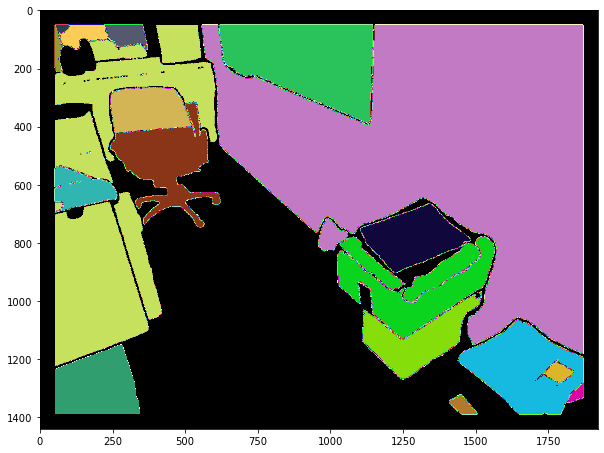

depthCheck [ 3.50875163  3.50504559  3.49353706 ...  0.89471238 -0.01676551
 -0.01939819]
The Found Projection instance 163
Mapping {-100: -100, 0: 94, 2: 0, 8: 1, 152: 0, 153: 0, 158: 0, 161: 2, 163: 1179, 164: 0, 165: 0, 166: 1, 167: 0, 170: 8, 171: 5, 172: 0, 173: 20, 174: 0, 175: 1, 176: 0, 177: 0, 179: 0, 180: 11, 181: 8, 182: 5, 183: 2, 184: 1, 186: 1, 187: 0, 195: 0, 200: 0, 202: 0}
MaxId 205
The Found Projection instance 0
Mapping {-100: -100, 0: 1328, 2: 0, 8: 108, 152: 2, 153: 0, 158: 5, 161: 19, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0, 195: 0, 200: 0, 202: 0}
MaxId 205
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 2: 0, 8: 0, 152: 0, 153: 0, 158: 0, 161: 0, 163: 32, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 102, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0, 195: 0, 20

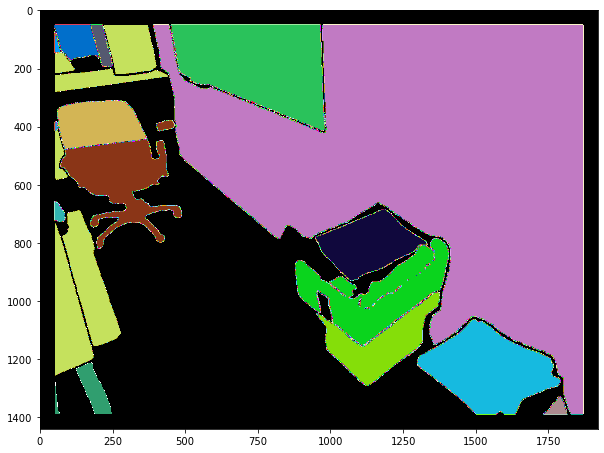

depthCheck [ 3.46102223  3.57583868  3.48092205 ... -0.00431271 -0.00920981
  0.00383721]
The Found Projection instance 163
Mapping {-100: -100, 0: 98, 2: 0, 8: 2, 152: 0, 153: 0, 158: 0, 161: 2, 163: 1626, 164: 2, 165: 0, 166: 1, 167: 0, 170: 9, 171: 8, 172: 0, 173: 20, 174: 0, 175: 1, 177: 0, 179: 0, 180: 12, 181: 9, 182: 5, 183: 0, 184: 1, 186: 1, 187: 0, 195: 0, 202: 0}
MaxId 209
The Found Projection instance 0
Mapping {-100: -100, 0: 1776, 2: 2, 8: 119, 152: 1, 153: 0, 158: 6, 161: 20, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 177: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0, 195: 0, 202: 0}
MaxId 209
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 2: 0, 8: 0, 152: 0, 153: 0, 158: 0, 161: 0, 163: 28, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 177: 0, 179: 0, 180: 111, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 187: 0, 195: 0, 202: 0}
MaxId 209
The Found Projection ins

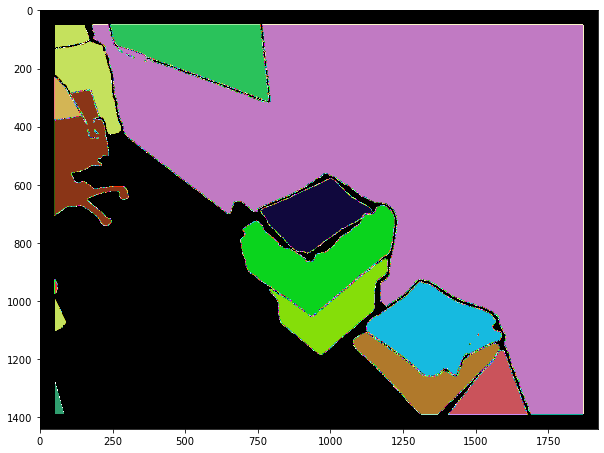

depthCheck [ 3.54677368e+00  3.69472699e+00  3.57828522e+00 ... -2.59905261e-02
 -1.13624128e-03 -2.21998482e-02]
The Found Projection instance 163
Mapping {-100: -100, 0: 92, 8: 0, 158: 0, 161: 2, 163: 1943, 164: 0, 165: 0, 166: 1, 167: 0, 170: 15, 171: 12, 172: 0, 173: 15, 174: 0, 175: 0, 180: 14, 181: 8, 182: 3, 183: 0, 184: 1, 186: 1, 202: 0, 209: 2}
MaxId 211
The Found Projection instance 181
Mapping {-100: -100, 0: 12, 8: 0, 158: 0, 161: 0, 163: 6, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 4, 172: 0, 173: 0, 174: 1, 175: 0, 180: 0, 181: 149, 182: 1, 183: 4, 184: 0, 186: 0, 202: 2, 209: 0}
MaxId 211
The Found Projection instance 209
Mapping {-100: -100, 0: 0, 8: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 186: 0, 202: 0, 209: 14}
MaxId 211
The Found Projection instance 170
Mapping {-100: -100, 0: 28, 8: 0, 158: 0, 161: 0, 163: 0, 164: 0, 165: 2, 166: 0, 167: 0, 170: 132, 171: 

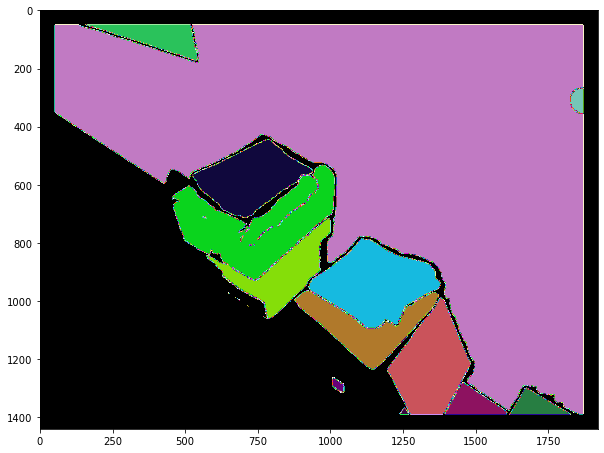

depthCheck [ 3.82619327  3.86339768  3.89713408 ... -0.22637141 -0.21011505
 -0.07955714]
The Found Projection instance 163
Mapping {-100: -100, 0: 25, 163: 1718, 164: 0, 165: 0, 166: 1, 167: 0, 170: 21, 171: 18, 172: 0, 173: 12, 174: 0, 175: 0, 181: 6, 182: 2, 183: 0, 186: 0, 202: 0, 209: 1, 211: 0, 212: 0}
MaxId 216
The Found Projection instance 211
Mapping {-100: -100, 0: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 0, 211: 5, 212: 1}
MaxId 216
The Found Projection instance 170
Mapping {-100: -100, 0: 35, 163: 5, 164: 6, 165: 9, 166: 0, 167: 0, 170: 197, 171: 20, 172: 0, 173: 4, 174: 0, 175: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 0, 211: 0, 212: 0}
MaxId 216
The Found Projection instance 181
Mapping {-100: -100, 0: 10, 163: 21, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 15, 172: 0, 173: 0, 174: 2, 175: 0, 181: 172, 182: 2, 183: 4, 186: 0, 202: 2, 209: 0, 211: 0, 212: 0}
MaxId 216
Th

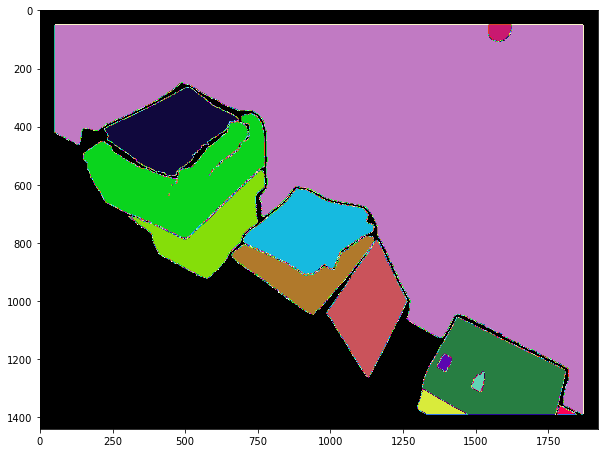

depthCheck [4.17600728 4.11695509 4.00061576 ... 0.06551659 0.05262121 0.00997145]
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 163: 1360, 164: 0, 165: 0, 166: 0, 167: 0, 170: 23, 171: 20, 172: 0, 173: 11, 174: 0, 175: 0, 181: 5, 182: 2, 183: 0, 186: 0, 202: 0, 209: 2, 211: 0, 212: 0, 216: 0}
MaxId 221
The Found Projection instance 0
Mapping {-100: -100, 0: 892, 163: 3, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 6, 211: 0, 212: 6, 216: 0}
MaxId 221
The Found Projection instance 211
Mapping {-100: -100, 0: 0, 163: 1, 164: 0, 165: 0, 166: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 0, 211: 57, 212: 1, 216: 0}
MaxId 221
The Found Projection instance 170
Mapping {-100: -100, 0: 23, 163: 5, 164: 9, 165: 14, 166: 0, 167: 0, 170: 220, 171: 17, 172: 0, 173: 6, 174: 0, 175: 0, 181: 0, 182: 0, 183: 0, 186: 1, 202: 0, 209: 0, 211: 0, 212: 0,

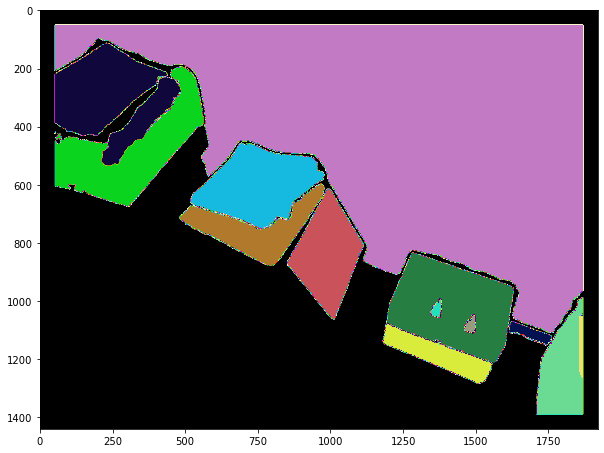

depthCheck [ 4.17700593e+00  4.15929704e+00  4.97471900e+00 ... -2.84669465e-02
 -2.59320373e-03  3.66928161e-02]
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 163: 1486, 165: 0, 167: 0, 170: 27, 171: 16, 172: 0, 173: 5, 174: 0, 181: 2, 182: 1, 183: 0, 186: 0, 202: 0, 209: 1, 211: 0, 212: 0, 216: 0, 221: 0, 223: 0}
MaxId 226
The Found Projection instance 0
Mapping {-100: -100, 0: 820, 163: 10, 165: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 11, 211: 2, 212: 4, 216: 9, 221: 0, 223: 1}
MaxId 226
The Found Projection instance 211
Mapping {-100: -100, 0: 0, 163: 16, 165: 0, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 0, 211: 72, 212: 3, 216: 0, 221: 0, 223: 0}
MaxId 226
The Found Projection instance 181
Mapping {-100: -100, 0: 8, 163: 67, 165: 0, 167: 0, 170: 0, 171: 30, 172: 0, 173: 0, 174: 1, 181: 182, 182: 4, 183: 4, 186: 0, 202: 1, 209: 0, 211: 0, 212: 0, 216: 0, 221: 0,

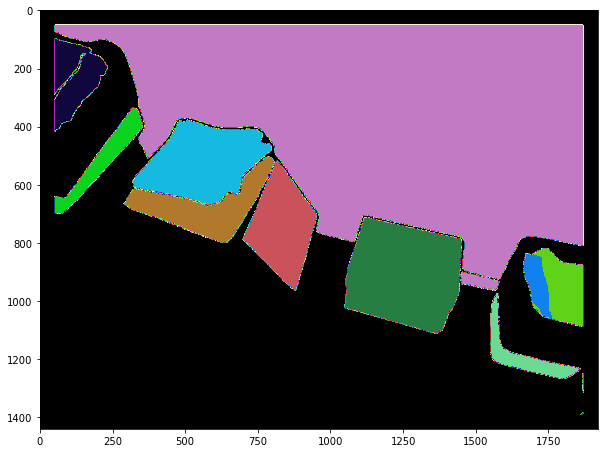

depthCheck [ 4.32898151e+00  4.34728514e+00  3.72836525e+00 ... -1.24991072e-03
 -4.82021623e-03 -9.07450088e-04]
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 163: 2125, 167: 0, 170: 16, 171: 13, 172: 0, 173: 0, 174: 0, 181: 0, 182: 1, 183: 0, 186: 0, 202: 0, 209: 1, 211: 0, 212: 0, 216: 0, 221: 0, 223: 0, 226: 0, 227: 0}
MaxId 230
The Found Projection instance 0
Mapping {-100: -100, 0: 756, 163: 12, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 16, 211: 7, 212: 4, 216: 15, 221: 6, 223: 2, 226: 0, 227: 0}
MaxId 230
The Found Projection instance 211
Mapping {-100: -100, 0: 0, 163: 36, 167: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 181: 0, 182: 0, 183: 0, 186: 0, 202: 0, 209: 0, 211: 96, 212: 2, 216: 0, 221: 0, 223: 0, 226: 0, 227: 0}
MaxId 230
The Found Projection instance 181
Mapping {-100: -100, 0: 2, 163: 105, 167: 0, 170: 0, 171: 11, 172: 0, 173: 0, 174: 0, 181: 173, 182: 4, 183: 4, 186: 0, 202: 1, 209: 0, 211: 0, 212: 

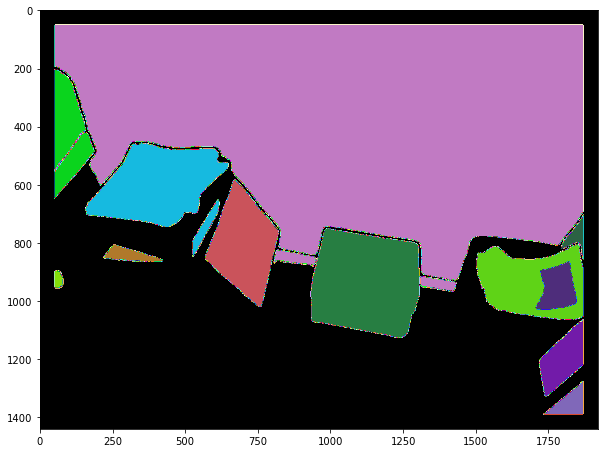

depthCheck [ 4.27923618  4.25670635  4.68053532 ... -0.08778168 -0.09758324
 -0.01304281]
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 163: 2960, 170: 1, 171: 0, 172: 0, 174: 0, 181: 1, 182: 1, 183: 0, 202: 0, 209: 6, 211: 5, 212: 0, 216: 0, 218: 2, 221: 0, 223: 0, 226: 0, 227: 0, 230: 0, 232: 0, 233: 0}
MaxId 234
The Found Projection instance 230
Mapping {-100: -100, 0: 0, 163: 2, 170: 0, 171: 0, 172: 0, 174: 0, 181: 0, 182: 0, 183: 0, 202: 0, 209: 0, 211: 0, 212: 0, 216: 0, 218: 0, 221: 0, 223: 0, 226: 3, 227: 0, 230: 8, 232: 2, 233: 0}
MaxId 234
The Found Projection instance 0
Mapping {-100: -100, 0: 154, 163: 27, 170: 0, 171: 0, 172: 0, 174: 0, 181: 0, 182: 0, 183: 0, 202: 0, 209: 27, 211: 22, 212: 4, 216: 14, 218: 0, 221: 0, 223: 2, 226: 0, 227: 0, 230: 0, 232: 0, 233: 0}
MaxId 234
The Found Projection instance 211
Mapping {-100: -100, 0: 2, 163: 37, 170: 0, 171: 0, 172: 0, 174: 0, 181: 0, 182: 0, 183: 0, 202: 0, 209: 0, 211: 174, 212: 3, 216: 0, 218: 0, 221: 0, 22

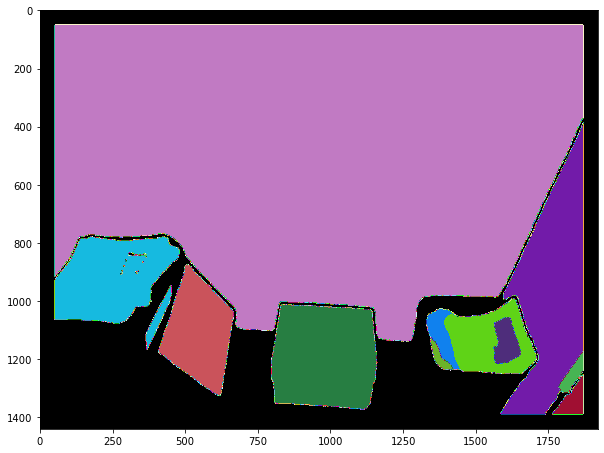

depthCheck [ 4.2272811   4.21585337  4.23786296 ... -0.02602061 -0.02992284
 -0.02688995]
The Found Projection instance 163
Mapping {-100: -100, 0: 0, 163: 3813, 171: 1, 172: 2, 181: 28, 182: 1, 183: 0, 202: 0, 209: 19, 211: 17, 218: 2, 221: 0, 226: 0, 227: 0, 230: 0, 232: 0, 233: 0}
MaxId 237
The Found Projection instance 230
Mapping {-100: -100, 0: 0, 163: 13, 171: 0, 172: 0, 181: 0, 182: 0, 183: 0, 202: 0, 209: 0, 211: 0, 218: 0, 221: 0, 226: 6, 227: 0, 230: 59, 232: 2, 233: 2}
MaxId 237
The Found Projection instance 181
Mapping {-100: -100, 0: 3, 163: 34, 171: 1, 172: 0, 181: 189, 182: 4, 183: 3, 202: 1, 209: 0, 211: 0, 218: 0, 221: 0, 226: 0, 227: 0, 230: 0, 232: 0, 233: 0}
MaxId 237
The Found Projection instance 226
Mapping {-100: -100, 0: 0, 163: 7, 171: 0, 172: 0, 181: 0, 182: 0, 183: 0, 202: 0, 209: 0, 211: 0, 218: 0, 221: 1, 226: 14, 227: 3, 230: 0, 232: 0, 233: 1}
MaxId 237
The Found Projection instance 209
Mapping {-100: -100, 0: 0, 163: 0, 171: 0, 172: 10, 181: 7, 182: 0, 

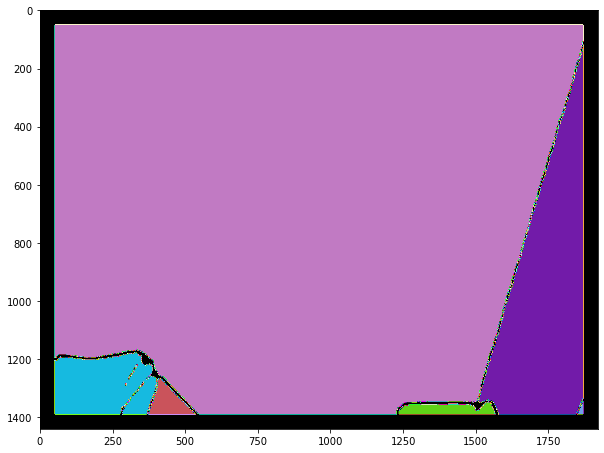

depthCheck [5.11653498e+00 4.41542021e+00 4.43730437e+00 ... 2.18164270e-03
 1.81522374e-03 2.55921776e-03]
The Found Projection instance 163
Mapping {-100: -100, 163: 4493, 170: 20, 171: 1, 181: 18, 182: 1, 218: 2, 230: 0}
MaxId 238
The Found Projection instance 230
Mapping {-100: -100, 163: 28, 170: 0, 171: 0, 181: 0, 182: 0, 218: 0, 230: 62}
MaxId 238
The Found Projection instance 170
Mapping {-100: -100, 163: 5, 170: 16, 171: 1, 181: 0, 182: 0, 218: 0, 230: 0}
MaxId 238
The Found Projection instance 163
Mapping {-100: -100, 163: 8, 170: 0, 171: 0, 181: 0, 182: 0, 218: 0, 230: 0}
MaxId 238
Current unique ids [-100    0    1    2    3]


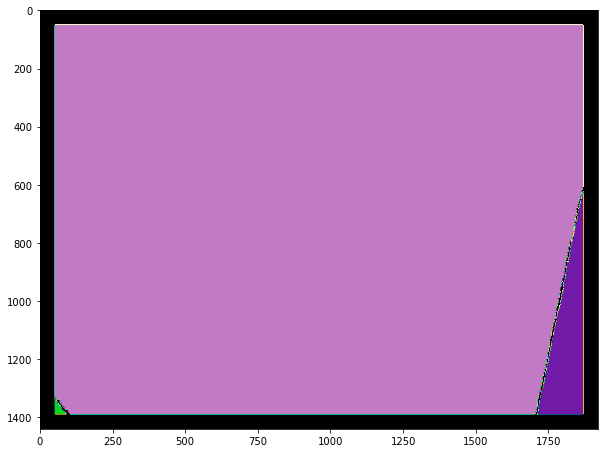

depthCheck [ 4.77733849e+00  4.58547177e+00  4.21644132e+00 ...  1.86091074e-02
  3.90698152e-03 -4.28320752e-03]
The Found Projection instance 163
Mapping {-100: -100, 163: 4769, 170: 27, 173: 34, 186: 1, 218: 2}
MaxId 238
The Found Projection instance 173
Mapping {-100: -100, 163: 0, 170: 0, 173: 29, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 170
Mapping {-100: -100, 163: 0, 170: 7, 173: 3, 186: 0, 218: 0}
MaxId 238
Current unique ids [-100    0    1    2]


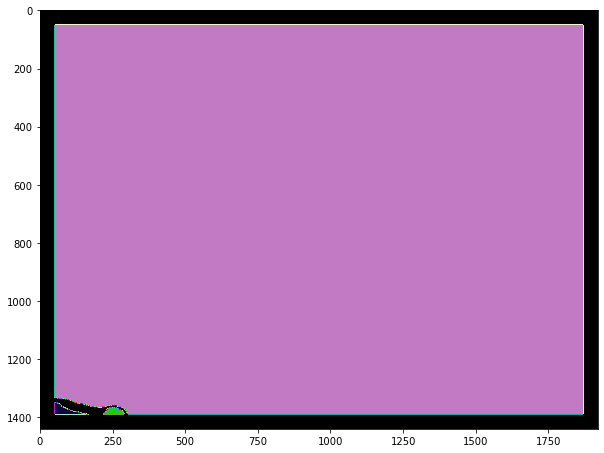

depthCheck [5.07452106 4.87989006 4.8839689  ... 0.00893188 0.0214787  0.02372417]
The Found Projection instance 163
Mapping {-100: -100, 163: 5332, 166: 1, 170: 21, 173: 58, 175: 1, 180: 30, 186: 1, 218: 2}
MaxId 238
The Found Projection instance 180
Mapping {-100: -100, 163: 11, 166: 0, 170: 0, 173: 0, 175: 0, 180: 16, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 180
Mapping {-100: -100, 163: 0, 166: 0, 170: 0, 173: 0, 175: 0, 180: 2, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 180
Mapping {-100: -100, 163: 6, 166: 0, 170: 0, 173: 0, 175: 0, 180: 29, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 173
Mapping {-100: -100, 163: 0, 166: 0, 170: 0, 173: 42, 175: 1, 180: 0, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 163
Mapping {-100: -100, 163: 4, 166: 0, 170: 0, 173: 0, 175: 0, 180: 0, 186: 0, 218: 0}
MaxId 238
The Found Projection instance 170
Mapping {-100: -100, 163: 0, 166: 0, 170: 6, 173: 0, 175: 0, 180: 0, 186: 0, 218: 0}
MaxId 238
Curr

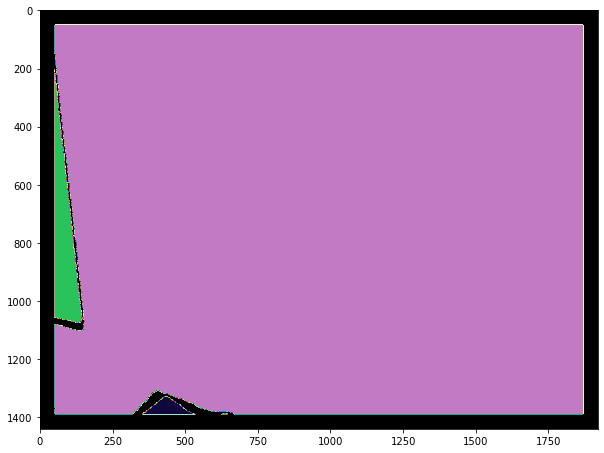

depthCheck [ 4.85484819e+00  4.87772771e+00  4.71459973e+00 ... -1.60361883e-04
  3.03260839e-03  7.76917241e-03]
The Found Projection instance 163
Mapping {-100: -100, 0: 103, 163: 5635, 166: 2, 170: 18, 173: 71, 175: 1, 180: 20, 186: 1, 218: 2}
MaxId 238
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 163: 72, 166: 0, 170: 0, 173: 0, 175: 0, 180: 226, 186: 0, 218: 0}
MaxId 238
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 163: 0, 166: 0, 170: 0, 173: 0, 175: 0, 180: 0, 186: 0, 218: 0}
MaxId 239
The Found Projection instance 0
Mapping {-100: -100, 0: 34, 163: 0, 166: 0, 170: 0, 173: 0, 175: 0, 180: 0, 186: 0, 218: 0}
MaxId 239
The Found Projection instance 173
Mapping {-100: -100, 0: 0, 163: 0, 166: 0, 170: 1, 173: 67, 175: 0, 180: 0, 186: 0, 218: 0}
MaxId 239
Current unique ids [-100    0    1    2    3    4]


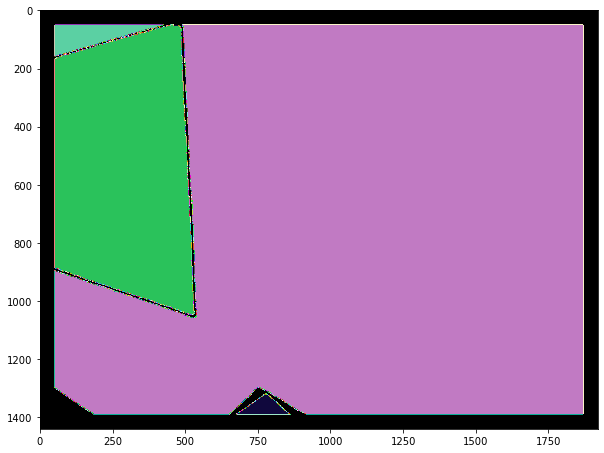

depthCheck [4.50507609 4.51747605 4.37690082 ... 0.05599308 0.01832405 0.05664101]
The Found Projection instance 163
Mapping {-100: -100, 0: 128, 8: 16, 153: 0, 158: 0, 161: 3, 163: 5041, 166: 1, 170: 1, 173: 63, 175: 1, 176: 0, 177: 0, 179: 0, 180: 13, 184: 2, 187: 0, 195: 1, 200: 0, 238: 11}
MaxId 239
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 8: 0, 153: 0, 158: 0, 161: 0, 163: 91, 166: 0, 170: 0, 173: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 463, 184: 0, 187: 0, 195: 0, 200: 0, 238: 0}
MaxId 239
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 8: 38, 153: 0, 158: 0, 161: 0, 163: 0, 166: 0, 170: 0, 173: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 187: 0, 195: 0, 200: 2, 238: 0}
MaxId 239
The Found Projection instance 0
Mapping {-100: -100, 0: 164, 8: 3, 153: 0, 158: 13, 161: 19, 163: 0, 166: 0, 170: 0, 173: 0, 175: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 187: 0, 195: 0, 200: 0, 238: 0}
MaxId 239
The Found Projection instance 158
Mapping {-100: -10

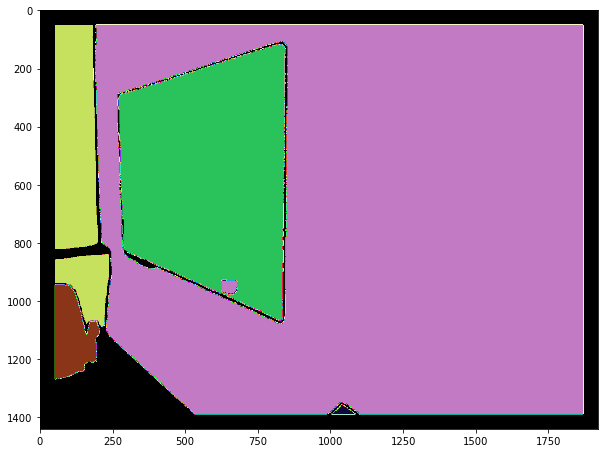

depthCheck [ 3.56395622  3.61302654  3.61159242 ... -0.01293844 -0.01394366
 -0.02603466]
The Found Projection instance 163
Mapping {-100: -100, 0: 97, 8: 8, 137: 0, 153: 0, 158: 0, 161: 2, 163: 4017, 166: 1, 173: 1, 176: 0, 177: 0, 179: 0, 180: 13, 184: 1, 187: 0, 192: 0, 195: 1, 200: 0, 238: 11}
MaxId 239
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 8: 0, 137: 0, 153: 0, 158: 0, 161: 0, 163: 120, 166: 0, 173: 0, 176: 0, 177: 0, 179: 0, 180: 699, 184: 0, 187: 0, 192: 0, 195: 0, 200: 0, 238: 0}
MaxId 239
The Found Projection instance 200
Mapping {-100: -100, 0: 0, 8: 0, 137: 0, 153: 0, 158: 0, 161: 0, 163: 0, 166: 0, 173: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 187: 0, 192: 0, 195: 0, 200: 1, 238: 0}
MaxId 239
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 8: 97, 137: 0, 153: 0, 158: 0, 161: 0, 163: 1, 166: 0, 173: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 187: 0, 192: 0, 195: 0, 200: 2, 238: 0}
MaxId 239
The Found Projection instance 8
Mapping {-100: -1

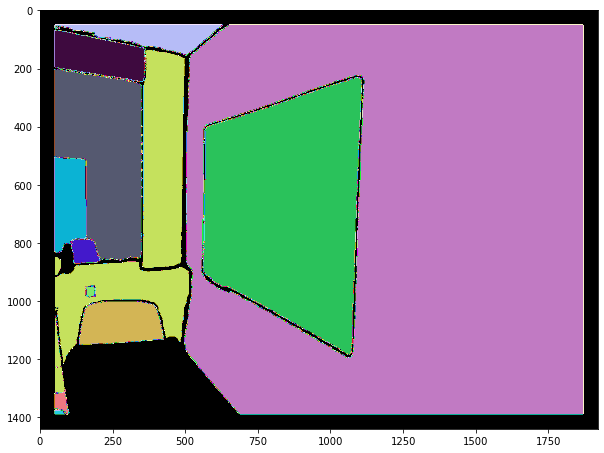

depthCheck [ 0.30308379  0.27936484  0.30944981 ... -4.15742464 -4.15300789
 -2.62948381]
The Found Projection instance 163
Mapping {-100: -100, 0: 45, 8: 3, 137: 0, 138: 0, 153: 0, 155: 0, 158: 0, 161: 2, 163: 3151, 176: 0, 177: 0, 179: 0, 180: 31, 184: 1, 187: 0, 192: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 11, 239: 0, 240: 0}
MaxId 246
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 8: 0, 137: 0, 138: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 140, 176: 0, 177: 0, 179: 0, 180: 892, 184: 0, 187: 0, 192: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 0, 240: 0}
MaxId 246
The Found Projection instance 239
Mapping {-100: -100, 0: 0, 8: 0, 137: 0, 138: 0, 153: 0, 155: 0, 158: 0, 161: 0, 163: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 187: 0, 192: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 15, 240: 0}
MaxId 246
The Found Projection instance 138
Mapping {-100: -100, 0: 0, 8: 3, 137: 1, 138: 4, 153: 0, 155: 0, 158: 0, 161: 0, 163: 0, 176: 0, 177: 0, 1

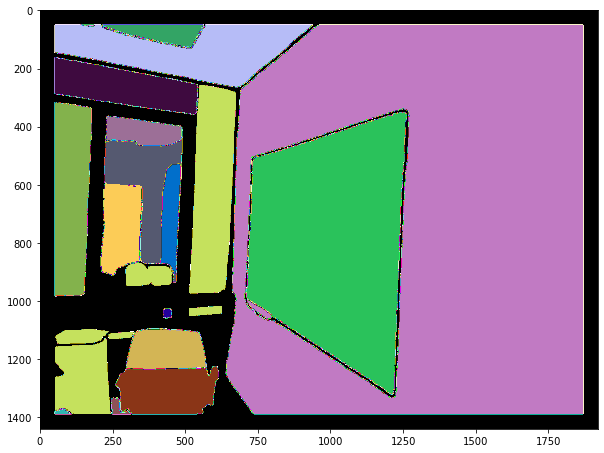

depthCheck [-1.88182333 -1.69342906  0.44898245 ... -0.12459773 -0.43221025
  0.07835197]
The Found Projection instance 163
Mapping {-100: -100, 0: 3, 8: 1, 106: 0, 137: 0, 138: 0, 140: 0, 148: 0, 158: 0, 161: 2, 163: 2099, 176: 0, 177: 0, 179: 0, 180: 48, 184: 1, 192: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 11, 239: 0, 240: 0, 246: 0, 247: 0}
MaxId 250
The Found Projection instance 200
Mapping {-100: -100, 0: 0, 8: 6, 106: 0, 137: 0, 138: 1, 140: 0, 148: 1, 158: 0, 161: 0, 163: 0, 176: 0, 177: 0, 179: 0, 180: 0, 184: 0, 192: 0, 193: 1, 195: 0, 199: 2, 200: 10, 205: 0, 238: 0, 239: 0, 240: 0, 246: 0, 247: 1}
MaxId 250
The Found Projection instance 180
Mapping {-100: -100, 0: 0, 8: 0, 106: 0, 137: 0, 138: 0, 140: 0, 148: 0, 158: 0, 161: 0, 163: 138, 176: 0, 177: 0, 179: 0, 180: 1048, 184: 0, 192: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 0, 240: 0, 246: 0, 247: 0}
MaxId 250
The Found Projection instance 239
Mapping {-100: -100, 0: 0, 8: 0, 106: 0, 137: 0, 138: 0, 1

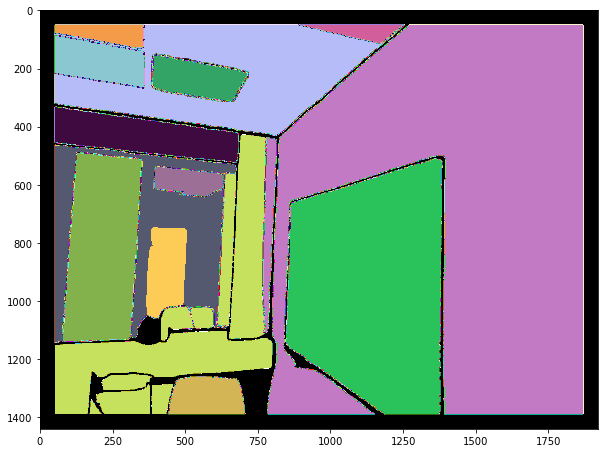

depthCheck [-2.02112019 -1.98671808 -1.80088233 ... -0.07275794 -0.06521585
 -0.05676553]
The Found Projection instance 163
Mapping {-100: -100, 8: 2, 137: 0, 138: 0, 140: 0, 148: 0, 158: 0, 163: 1601, 179: 0, 180: 69, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 11, 239: 0, 240: 0, 246: 0, 247: 0, 250: 0, 251: 0, 252: 0}
MaxId 253
The Found Projection instance 239
Mapping {-100: -100, 8: 0, 137: 0, 138: 0, 140: 0, 148: 0, 158: 0, 163: 4, 179: 0, 180: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 20, 240: 2, 246: 0, 247: 0, 250: 5, 251: 9, 252: 6}
MaxId 253
The Found Projection instance 180
Mapping {-100: -100, 8: 0, 137: 0, 138: 0, 140: 0, 148: 0, 158: 0, 163: 54, 179: 0, 180: 844, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 0, 240: 0, 246: 0, 247: 0, 250: 0, 251: 0, 252: 0}
MaxId 253
The Found Projection instance 138
Mapping {-100: -100, 8: 1, 137: 0, 138: 96, 140: 0, 148: 0, 158: 0, 163: 0, 179: 0, 180: 0, 193: 0, 195: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 0, 24

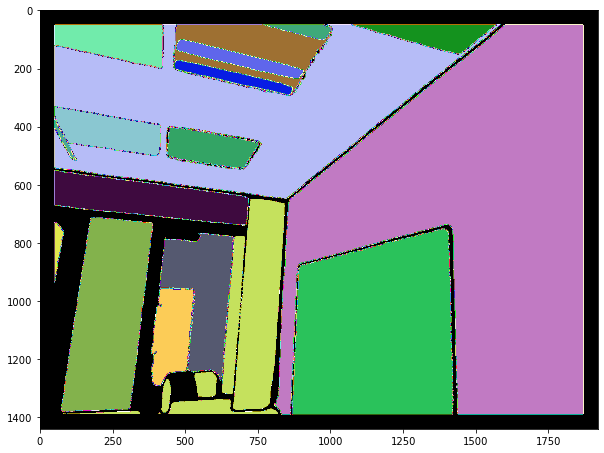

depthCheck [ 0.03656458  0.10794502  0.03527055 ... -0.05043724 -0.04661383
 -0.05350536]
The Found Projection instance 239
Mapping {-100: -100, 8: 6, 11: 0, 101: 0, 107: 0, 108: 0, 137: 0, 138: 0, 140: 0, 148: 0, 163: 5, 180: 0, 193: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 68, 240: 2, 246: 0, 247: 0, 250: 7, 251: 1, 252: 0, 253: 0, 254: 1, 255: 0, 257: 0, 258: 0, 259: 0}
MaxId 262
The Found Projection instance 163
Mapping {-100: -100, 8: 9, 11: 0, 101: 0, 107: 0, 108: 0, 137: 0, 138: 0, 140: 0, 148: 0, 163: 1326, 180: 91, 193: 0, 199: 0, 200: 0, 205: 0, 238: 11, 239: 0, 240: 0, 246: 0, 247: 0, 250: 0, 251: 0, 252: 0, 253: 0, 254: 0, 255: 0, 257: 0, 258: 0, 259: 0}
MaxId 262
The Found Projection instance 180
Mapping {-100: -100, 8: 0, 11: 0, 101: 0, 107: 0, 108: 0, 137: 0, 138: 0, 140: 0, 148: 0, 163: 46, 180: 857, 193: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 0, 240: 0, 246: 0, 247: 0, 250: 0, 251: 0, 252: 0, 253: 0, 254: 0, 255: 0, 257: 0, 258: 0, 259: 0}
MaxId 262
The Found Projectio

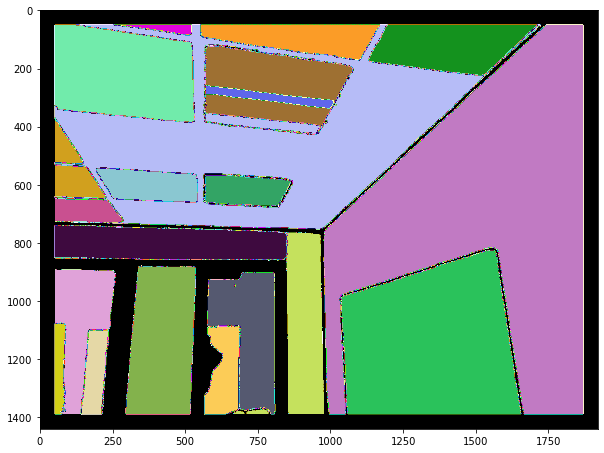

depthCheck [ 0.05837863  0.0897684  -0.08871753 ... -1.63465697 -1.58660092
 -1.56057245]
The Found Projection instance 239
Mapping {-100: -100, 8: 0, 11: 1, 69: 1, 76: 0, 94: 2, 97: 0, 100: 0, 101: 3, 105: 0, 107: 1, 108: 0, 109: 0, 112: 0, 130: 0, 131: 0, 138: 0, 163: 6, 180: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 206, 240: 15, 246: 8, 247: 0, 250: 6, 251: 0, 252: 0, 253: 3, 254: 2, 255: 2, 257: 0, 258: 0, 259: 0, 262: 2, 264: 0}
MaxId 266
The Found Projection instance 200
Mapping {-100: -100, 8: 15, 11: 12, 69: 0, 76: 0, 94: 0, 97: 5, 100: 0, 101: 0, 105: 2, 107: 0, 108: 2, 109: 0, 112: 0, 130: 0, 131: 2, 138: 8, 163: 0, 180: 0, 199: 6, 200: 29, 205: 1, 238: 0, 239: 0, 240: 0, 246: 0, 247: 9, 250: 0, 251: 0, 252: 0, 253: 0, 254: 0, 255: 0, 257: 0, 258: 0, 259: 0, 262: 0, 264: 0}
MaxId 266
The Found Projection instance 163
Mapping {-100: -100, 8: 4, 11: 0, 69: 0, 76: 0, 94: 0, 97: 0, 100: 0, 101: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 131: 0, 138: 0, 163: 778, 180: 108, 

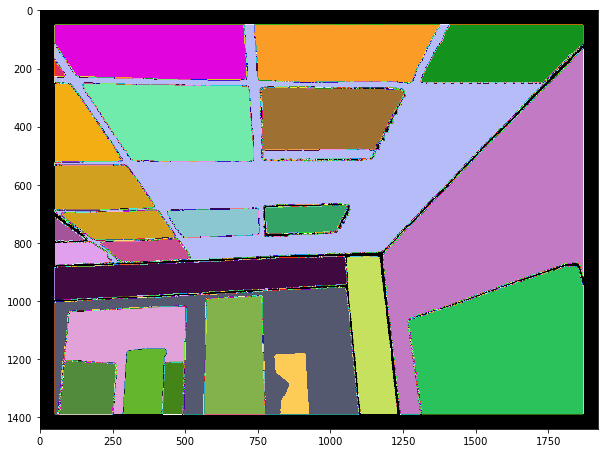

depthCheck [-0.04325769 -0.0407467  -0.04837791 ... -1.51789654 -1.57608917
 -1.53521256]
The Found Projection instance 239
Mapping {-100: -100, 8: 0, 11: 27, 69: 11, 76: 4, 90: 0, 94: 2, 97: 0, 100: 2, 101: 7, 105: 0, 107: 5, 108: 0, 109: 1, 112: 0, 130: 0, 138: 1, 163: 5, 180: 0, 199: 0, 200: 0, 205: 0, 238: 0, 239: 108, 240: 5, 246: 3, 247: 0, 250: 8, 251: 0, 252: 0, 253: 9, 254: 18, 255: 7, 257: 1, 258: 1, 259: 0, 262: 5, 264: 1}
MaxId 268
The Found Projection instance 97
Mapping {-100: -100, 8: 3, 11: 33, 69: 0, 76: 0, 90: 0, 94: 0, 97: 95, 100: 0, 101: 0, 105: 2, 107: 0, 108: 5, 109: 0, 112: 0, 130: 0, 138: 15, 163: 0, 180: 0, 199: 3, 200: 60, 205: 0, 238: 0, 239: 0, 240: 0, 246: 0, 247: 14, 250: 0, 251: 0, 252: 0, 253: 0, 254: 0, 255: 0, 257: 0, 258: 0, 259: 0, 262: 0, 264: 0}
MaxId 268
The Found Projection instance 163
Mapping {-100: -100, 8: 2, 11: 0, 69: 0, 76: 0, 90: 0, 94: 0, 97: 0, 100: 0, 101: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 138: 0, 163: 513, 180: 69, 1

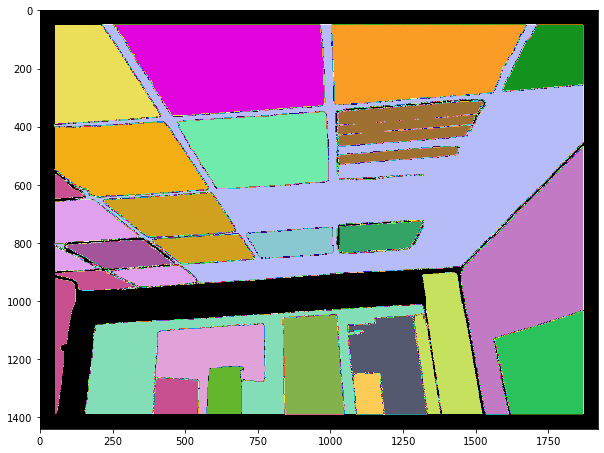

depthCheck [-0.34309972 -0.15321899  0.02292238 ...  0.00095594  0.00140792
  0.00541373]
The Found Projection instance 239
Mapping {-100: -100, 8: 1, 11: 18, 53: 0, 69: 30, 71: 0, 76: 9, 79: 1, 82: 0, 90: 0, 94: 5, 97: 0, 100: 4, 101: 6, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 138: 1, 163: 1, 180: 0, 199: 0, 200: 0, 205: 0, 239: 96, 240: 14, 246: 8, 247: 0, 250: 12, 251: 0, 252: 0, 253: 22, 254: 27, 255: 1, 257: 3, 258: 1, 259: 1, 262: 4, 264: 6}
MaxId 268
The Found Projection instance 200
Mapping {-100: -100, 8: 8, 11: 37, 53: 0, 69: 0, 71: 0, 76: 0, 79: 0, 82: 0, 90: 0, 94: 0, 97: 118, 100: 0, 101: 0, 105: 2, 107: 0, 108: 9, 109: 0, 112: 0, 130: 0, 138: 27, 163: 0, 180: 0, 199: 13, 200: 195, 205: 6, 239: 0, 240: 0, 246: 0, 247: 19, 250: 0, 251: 0, 252: 0, 253: 0, 254: 0, 255: 0, 257: 0, 258: 0, 259: 0, 262: 0, 264: 0}
MaxId 268
The Found Projection instance 240
Mapping {-100: -100, 8: 7, 11: 136, 53: 0, 69: 0, 71: 0, 76: 1, 79: 0, 82: 0, 90: 0, 94: 0, 97: 1, 100: 0, 101: 0, 

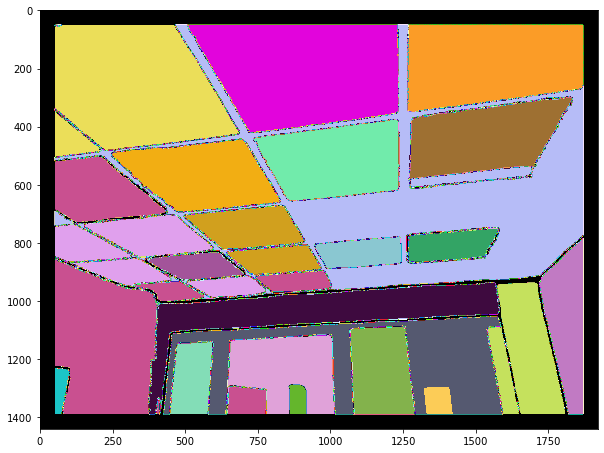

depthCheck [-0.1485726  -0.15015784 -0.14747847 ...  0.00130624  0.00344934
  0.00260557]
The Found Projection instance 239
Mapping {-100: -100, 8: 0, 11: 43, 53: 0, 61: 0, 69: 70, 71: 0, 76: 25, 79: 0, 82: 0, 90: 0, 94: 15, 97: 0, 100: 5, 101: 10, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 138: 1, 199: 0, 200: 0, 205: 0, 239: 100, 240: 7, 246: 6, 247: 0, 250: 11, 251: 0, 253: 17, 254: 27, 257: 2, 258: 0, 259: 0, 262: 9, 264: 15}
MaxId 269
The Found Projection instance 200
Mapping {-100: -100, 8: 5, 11: 33, 53: 0, 61: 0, 69: 0, 71: 0, 76: 0, 79: 0, 82: 0, 90: 0, 94: 0, 97: 98, 100: 0, 101: 0, 105: 2, 107: 0, 108: 11, 109: 0, 112: 0, 130: 0, 138: 88, 199: 10, 200: 100, 205: 0, 239: 0, 240: 0, 246: 0, 247: 12, 250: 0, 251: 0, 253: 0, 254: 0, 257: 0, 258: 0, 259: 0, 262: 0, 264: 0}
MaxId 269
The Found Projection instance 11
Mapping {-100: -100, 8: 0, 11: 67, 53: 1, 61: 0, 69: 0, 71: 0, 76: 0, 79: 0, 82: 0, 90: 0, 94: 0, 97: 2, 100: 0, 101: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 1

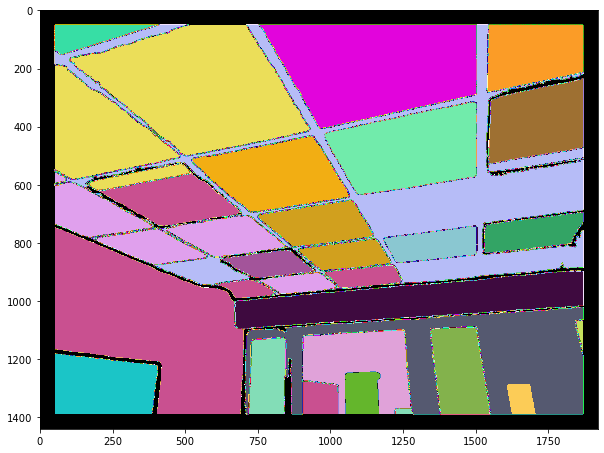

depthCheck [-0.19287072 -0.18770792 -0.18520082 ...  0.01545701  0.0101885
  0.00071804]
The Found Projection instance 239
Mapping {-100: -100, 11: 58, 53: 0, 59: 0, 61: 0, 69: 37, 71: 0, 76: 28, 79: 0, 82: 0, 90: 0, 94: 15, 97: 0, 100: 12, 101: 20, 105: 0, 107: 4, 108: 0, 109: 1, 112: 0, 130: 0, 131: 0, 138: 1, 199: 0, 200: 0, 239: 119, 240: 16, 246: 10, 247: 0, 250: 20, 251: 0, 253: 21, 254: 31, 257: 0, 259: 0, 262: 12, 264: 28, 266: 0, 269: 1}
MaxId 270
The Found Projection instance 11
Mapping {-100: -100, 11: 1387, 53: 153, 59: 0, 61: 0, 69: 2, 71: 0, 76: 0, 79: 0, 82: 0, 90: 0, 94: 0, 97: 5, 100: 0, 101: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 131: 0, 138: 0, 199: 0, 200: 3, 239: 1, 240: 12, 246: 0, 247: 0, 250: 0, 251: 0, 253: 0, 254: 0, 257: 0, 259: 0, 262: 0, 264: 0, 266: 0, 269: 0}
MaxId 270
The Found Projection instance 200
Mapping {-100: -100, 11: 53, 53: 0, 59: 0, 61: 0, 69: 0, 71: 0, 76: 0, 79: 0, 82: 0, 90: 0, 94: 0, 97: 99, 100: 0, 101: 0, 105: 2, 107: 0, 108:

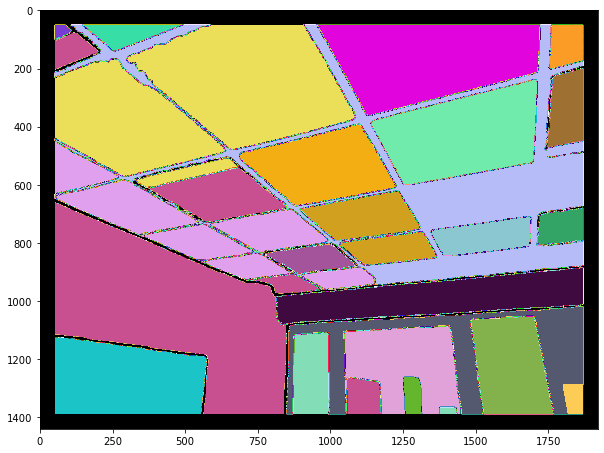

depthCheck [-0.24841182 -0.22463121 -0.24772621 ...  0.00911585  0.00452612
  0.02121183]
The Found Projection instance 239
Mapping {-100: -100, 11: 46, 53: 0, 59: 0, 61: 0, 62: 0, 69: 53, 71: 0, 76: 36, 79: 0, 81: 0, 82: 0, 90: 0, 94: 26, 97: 0, 100: 5, 101: 22, 105: 0, 107: 3, 108: 0, 109: 0, 112: 0, 130: 0, 138: 1, 143: 0, 199: 0, 200: 0, 239: 142, 240: 10, 246: 12, 247: 0, 250: 26, 251: 0, 253: 2, 254: 38, 257: 0, 259: 0, 262: 0, 264: 20, 269: 2}
MaxId 271
The Found Projection instance 11
Mapping {-100: -100, 11: 1870, 53: 252, 59: 0, 61: 0, 62: 0, 69: 1, 71: 0, 76: 0, 79: 0, 81: 0, 82: 0, 90: 0, 94: 0, 97: 9, 100: 0, 101: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 1, 130: 0, 138: 12, 143: 0, 199: 0, 200: 28, 239: 0, 240: 251, 246: 0, 247: 2, 250: 0, 251: 0, 253: 0, 254: 0, 257: 0, 259: 0, 262: 0, 264: 0, 269: 0}
MaxId 271
The Found Projection instance 97
Mapping {-100: -100, 11: 53, 53: 0, 59: 0, 61: 0, 62: 0, 69: 0, 71: 0, 76: 0, 79: 0, 81: 0, 82: 0, 90: 0, 94: 0, 97: 114, 100: 0, 1

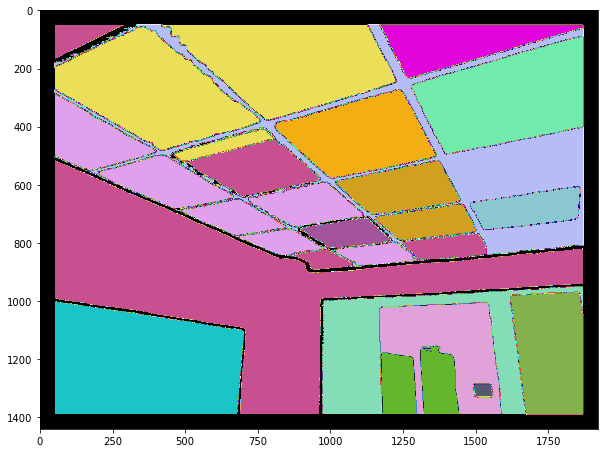

depthCheck [-0.20980957 -0.22453319 -0.22528022 ...  0.03322912  0.02911228
  0.02766312]
The Found Projection instance 76
Mapping {-100: -100, 8: 0, 11: 48, 53: 0, 59: 0, 61: 0, 62: 0, 69: 41, 71: 1, 76: 420, 78: 0, 79: 0, 81: 1, 82: 0, 88: 0, 90: 0, 94: 40, 96: 0, 97: 0, 98: 0, 99: 0, 100: 4, 101: 29, 102: 0, 105: 0, 107: 0, 108: 0, 109: 1, 112: 0, 130: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 148: 0, 193: 0, 200: 0, 239: 64, 240: 4, 246: 0, 250: 22, 251: 0, 254: 36}
MaxId 271
The Found Projection instance 11
Mapping {-100: -100, 8: 1, 11: 2147, 53: 225, 59: 0, 61: 0, 62: 0, 69: 14, 71: 0, 76: 0, 78: 2, 79: 0, 81: 0, 82: 0, 88: 1, 90: 0, 94: 0, 96: 0, 97: 3, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 107: 0, 108: 0, 109: 0, 112: 0, 130: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 148: 0, 193: 0, 200: 1, 239: 3, 240: 3, 246: 0, 250: 0, 251: 0, 254: 0}
MaxId 271
The Found Projection instance 53
Mapping {-100: -100, 8: 0, 11: 16, 53: 2499, 59: 5, 61: 37, 62: 1, 69: 0, 71: 0, 76: 0, 

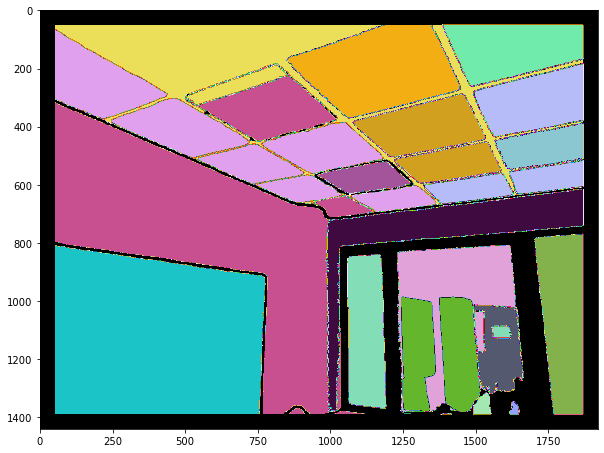

depthCheck [-0.44900108 -0.4047907  -0.22512829 ...  0.02867616  0.02106699
  0.01823803]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 8: 0, 11: 65, 47: 0, 51: 0, 53: 0, 59: 0, 61: 0, 62: 0, 69: 60, 71: 0, 76: 24, 78: 0, 79: 0, 82: 0, 88: 0, 90: 0, 94: 38, 96: 0, 97: 0, 98: 0, 99: 0, 100: 10, 101: 25, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 193: 0, 200: 0, 239: 41, 240: 4, 250: 12, 251: 0, 254: 9}
MaxId 273
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 8: 1, 11: 2381, 47: 0, 51: 0, 53: 175, 59: 0, 61: 0, 62: 0, 69: 41, 71: 0, 76: 2, 78: 4, 79: 0, 82: 0, 88: 4, 90: 0, 94: 0, 96: 0, 97: 1, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 193: 0, 200: 1, 239: 4, 240: 4, 250: 0, 251: 0, 254: 0}
MaxId 273
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 8: 0

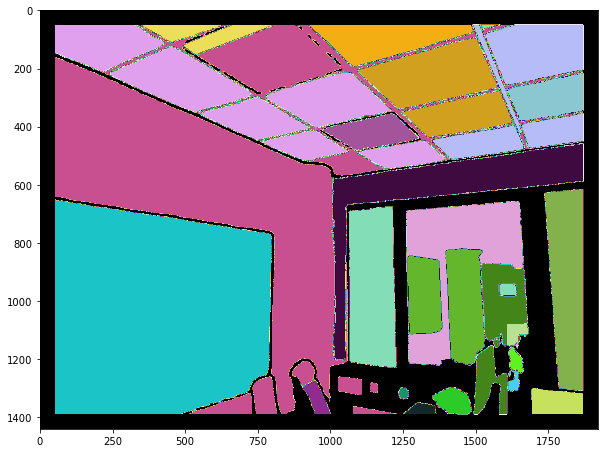

depthCheck [ 1.68351678  1.74012351  1.74177145 ... -0.22621464 -0.41911657
  0.01219454]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 8: 0, 11: 2507, 46: 0, 47: 0, 51: 0, 53: 137, 59: 0, 61: 0, 62: 0, 69: 72, 71: 0, 76: 2, 78: 4, 82: 0, 88: 4, 90: 0, 94: 0, 96: 2, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 200: 0, 239: 5, 240: 4, 250: 0, 265: 0, 266: 0, 273: 0}
MaxId 277
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 8: 0, 11: 208, 46: 0, 47: 18, 51: 0, 53: 3743, 59: 5, 61: 34, 62: 1, 69: 0, 71: 0, 76: 0, 78: 0, 82: 0, 88: 0, 90: 0, 94: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 140: 0, 143: 0, 200: 0, 239: 0, 240: 0, 250: 0, 265: 0, 266: 0, 273: 0}
MaxId 277
The Found Projection instance 101

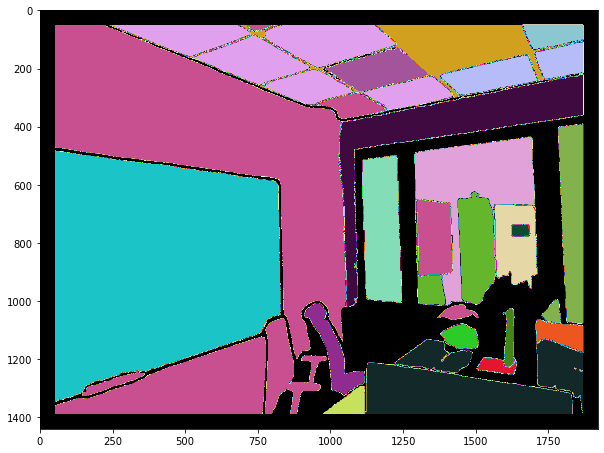

depthCheck [ 1.83688153  2.060824    1.74733764 ...  0.3243864  -0.10721295
 -0.558416  ]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 8: 0, 11: 3066, 46: 0, 47: 0, 51: 0, 53: 138, 59: 0, 61: 0, 62: 0, 69: 75, 71: 0, 76: 0, 78: 3, 88: 4, 96: 20, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 148: 0, 153: 0, 193: 0, 200: 0, 239: 7, 240: 5, 250: 0, 265: 0, 266: 0, 273: 0, 277: 0}
MaxId 279
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 8: 0, 11: 179, 46: 0, 47: 16, 51: 0, 53: 4013, 59: 7, 61: 34, 62: 2, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 130: 0, 131: 0, 134: 0, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 148: 0, 153: 0, 193: 0, 200: 0, 239: 0, 240: 0, 250: 0, 265: 0, 266: 0, 273:

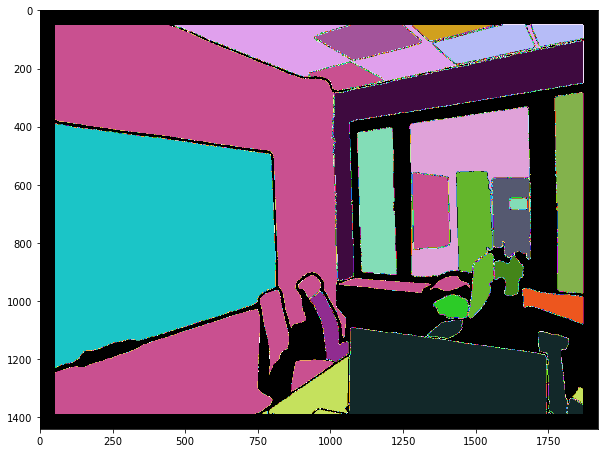

depthCheck [ 1.95868068  2.07465948  2.11674149 ... -0.51266301 -0.67262297
 -0.73501617]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 8: 1, 11: 2351, 46: 0, 47: 0, 51: 0, 53: 185, 59: 0, 61: 0, 62: 0, 69: 34, 71: 0, 76: 0, 78: 4, 88: 3, 96: 2, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 134: 0, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 153: 0, 193: 0, 200: 0, 239: 9, 240: 1, 265: 0, 266: 0, 273: 0, 277: 0}
MaxId 279
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 8: 0, 11: 160, 46: 0, 47: 15, 51: 0, 53: 3997, 59: 6, 61: 36, 62: 1, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 112: 0, 114: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 134: 0, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 153: 0, 193: 

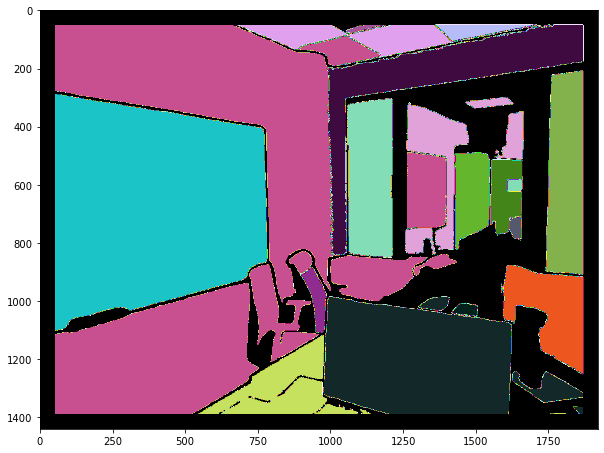

depthCheck [ 0.42465015  0.17811841  0.26404949 ... -0.08378372 -0.0249148
 -0.2301535 ]
The Found Projection instance 108
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 3, 11: 97, 13: 0, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 0, 51: 0, 53: 0, 59: 0, 61: 0, 62: 0, 69: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 115, 98: 0, 99: 0, 101: 0, 102: 0, 105: 41, 106: 1, 107: 0, 108: 298, 110: 0, 112: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 133: 0, 137: 0, 138: 114, 139: 0, 140: 2, 145: 0, 147: 0, 148: 1, 153: 0, 155: 0, 192: 0, 193: 0, 200: 108, 239: 0, 240: 70, 265: 1, 273: 0, 277: 0}
MaxId 280
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 1, 8: 0, 11: 123, 13: 0, 14: 0, 15: 0, 17: 0, 20: 0, 23: 0, 46: 0, 47: 13, 51: 0, 53: 3607, 59: 6, 61: 36, 62: 0, 69: 0, 76: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 101: 0, 102: 0, 105: 0, 106: 0, 107: 0, 108: 0, 110: 0, 112: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 13

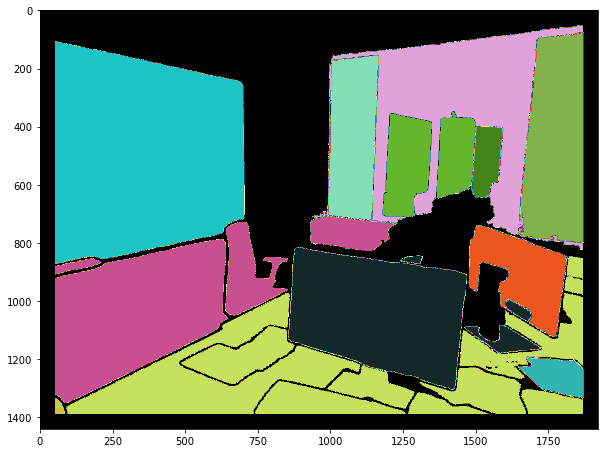

depthCheck [ 0.25218514  0.4124448   0.38028053 ... -0.03109257 -0.03122443
 -0.02047489]
The Found Projection instance 8
Mapping {-100: -100, 0: 3, 2: 102, 3: 503, 8: 1516, 11: 20, 13: 82, 14: 77, 15: 22, 17: 59, 19: 10, 20: 3, 23: 51, 46: 0, 47: 0, 51: 0, 53: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 6, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 33, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 133: 3, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 147: 0, 148: 0, 153: 1, 155: 0, 158: 0, 179: 0, 192: 0, 193: 0, 199: 0, 200: 0, 240: 0, 263: 0, 265: 0, 266: 0, 273: 0, 277: 0}
MaxId 280
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 0, 11: 66, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 46: 0, 47: 7, 51: 0, 53: 3222, 59: 7, 61: 40, 62: 1, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 131: 0, 132: 0, 133: 0, 137: 0, 138: 0,

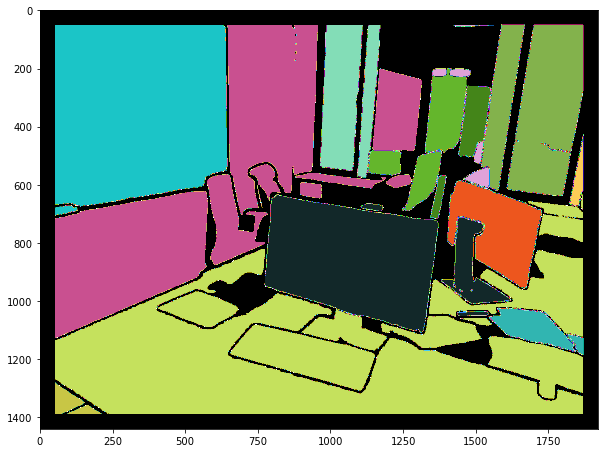

depthCheck [-2.29150089 -2.0955095  -1.65836539 ... -0.06073107 -0.033011
 -0.04414512]
The Found Projection instance 8
Mapping {-100: -100, 0: 16, 2: 372, 3: 554, 8: 1938, 10: 0, 11: 29, 13: 92, 14: 85, 15: 27, 17: 57, 19: 19, 20: 4, 23: 51, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 19, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 31, 125: 0, 127: 0, 130: 0, 132: 0, 133: 3, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 148: 0, 153: 0, 155: 0, 193: 0, 200: 0, 240: 0, 265: 0}
MaxId 280
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 0, 10: 0, 11: 7, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 46: 0, 47: 1, 51: 0, 53: 3145, 59: 7, 61: 40, 62: 2, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 132: 0, 133: 0, 137: 0, 138: 0, 139: 0, 140: 0, 143: 0, 145: 0, 148: 0, 153: 0, 155: 0, 193:

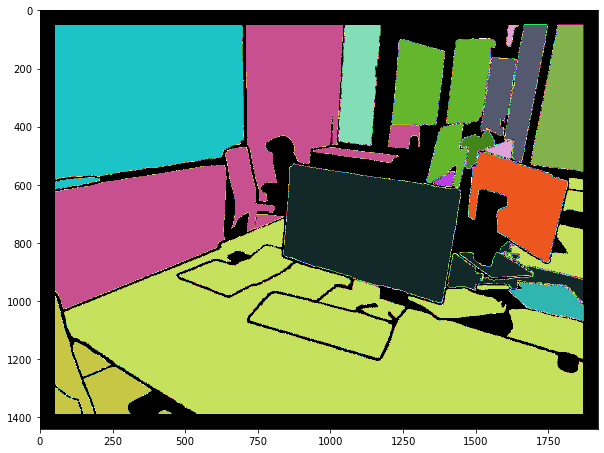

depthCheck [-2.55381128 -2.36283613 -2.34482614 ...  1.52635491  1.22455272
  1.20588383]
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 8: 0, 10: 0, 11: 253, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 46: 0, 47: 0, 51: 0, 53: 3994, 56: 2, 59: 5, 61: 40, 62: 2, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 130: 0, 132: 0, 133: 0, 134: 0, 137: 0, 143: 0, 147: 0, 148: 0, 153: 0, 200: 0, 240: 0, 277: 0}
MaxId 281
The Found Projection instance 8
Mapping {-100: -100, 0: 7, 2: 379, 3: 486, 8: 1967, 10: 0, 11: 43, 13: 80, 14: 85, 15: 25, 17: 50, 19: 14, 20: 3, 23: 51, 24: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 4, 108: 0, 110: 0, 115: 0, 116: 0, 120: 0, 124: 27, 125: 0, 127: 0, 130: 0, 132: 0, 133: 3, 134: 0, 137: 0, 143: 0, 147: 0, 148: 0, 153: 0, 200: 0, 240: 0, 277: 0}
MaxId 281
The Found 

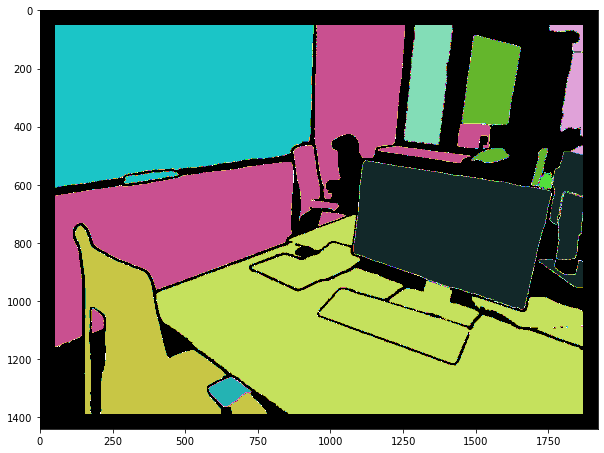

depthCheck [-2.44879914 -0.24523056 -0.23081451 ...  0.05443881  0.32741075
  0.25713671]
The Found Projection instance 11
Mapping {-100: -100, 0: 58, 2: 0, 3: 64, 7: 1025, 8: 14, 10: 0, 11: 3222, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 19, 23: 0, 24: 0, 34: 0, 46: 1, 47: 47, 51: 0, 53: 231, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 114: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 200: 0, 240: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 2: 0, 3: 0, 7: 0, 8: 0, 10: 0, 11: 540, 13: 0, 14: 0, 15: 0, 17: 0, 19: 0, 20: 0, 23: 0, 24: 0, 34: 0, 46: 0, 47: 1, 51: 0, 53: 4586, 56: 2, 59: 7, 61: 39, 62: 1, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 114: 0, 116: 0, 120: 0, 124: 0, 125: 0, 127: 0, 200: 0, 240: 0}
MaxId 282
The Found Projection instance 8
Mapping {-100: -100, 0: 4, 2: 219, 3: 374, 7: 0, 8: 1439, 10: 0, 11: 50, 13: 63, 14: 84, 15: 20, 17: 25, 19: 11, 20: 3, 23: 51, 2

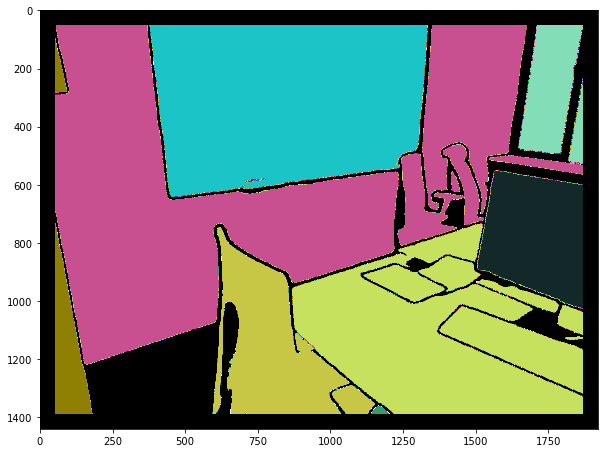

depthCheck [-0.31933185 -0.28236159 -0.22322027 ... -0.02465867 -0.01739387
 -0.02147072]
The Found Projection instance 7
Mapping {-100: -100, 0: 48, 1: 272, 2: 0, 3: 0, 7: 2294, 8: 0, 11: 33, 13: 0, 14: 0, 15: 0, 17: 0, 18: 241, 19: 0, 20: 0, 23: 0, 24: 0, 34: 15, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 98: 0, 106: 0, 115: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 0: 97, 1: 0, 2: 0, 3: 51, 7: 847, 8: 21, 11: 4018, 13: 0, 14: 0, 15: 0, 17: 0, 18: 0, 19: 0, 20: 24, 23: 0, 24: 0, 34: 0, 46: 2, 47: 53, 51: 0, 53: 276, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 98: 0, 106: 0, 115: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 7: 0, 8: 0, 11: 461, 13: 0, 14: 0, 15: 0, 17: 0, 18: 0, 19: 0, 20: 0, 23: 0, 24: 0, 34: 0, 46: 0, 47: 3, 51: 0, 53: 5246, 56: 2, 59: 7, 61: 33, 62: 2, 78: 0, 88: 0, 98: 0, 106: 0, 115: 0}
MaxId 282
The Found Projection instance 8
Mapping {-100: -100, 0: 0, 1: 0, 2: 49, 3

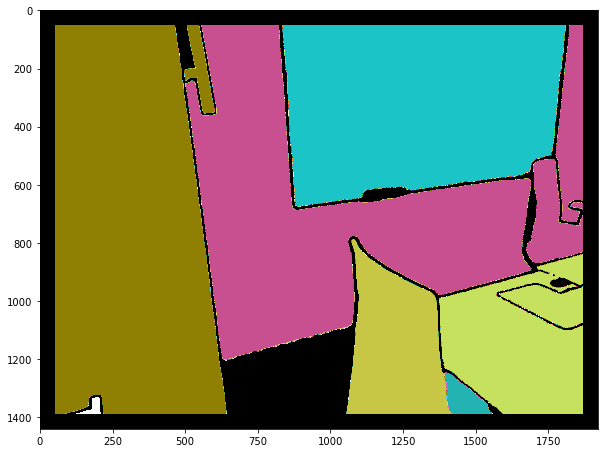

depthCheck [-0.35243011 -0.31169031 -0.25593153 ... -0.03541314 -0.0374724
 -0.02655763]
The Found Projection instance 7
Mapping {-100: -100, 0: 6, 1: 179, 3: 0, 6: 38, 7: 3425, 8: 0, 11: 199, 13: 0, 15: 0, 17: 0, 18: 508, 20: 0, 23: 0, 25: 12, 27: 2, 34: 0, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 1: 0, 3: 0, 6: 0, 7: 0, 8: 0, 11: 414, 13: 0, 15: 0, 17: 0, 18: 0, 20: 0, 23: 0, 25: 0, 27: 0, 34: 0, 46: 0, 47: 4, 53: 4618, 56: 2, 59: 5, 61: 27, 62: 1}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 11, 3: 0, 6: 157, 7: 0, 8: 0, 11: 0, 13: 0, 15: 0, 17: 0, 18: 1, 20: 0, 23: 0, 25: 2, 27: 0, 34: 0, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 282
The Found Projection instance 3
Mapping {-100: -100, 0: 18, 1: 0, 3: 554, 6: 0, 7: 0, 8: 146, 11: 64, 13: 5, 15: 3, 17: 21, 18: 0, 20: 2, 23: 0, 25: 0, 27: 0, 34: 0, 46: 1, 47: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0}
MaxId 282
The Found P

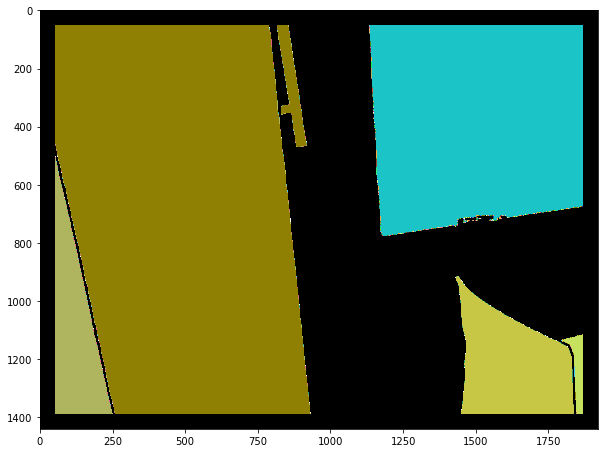

depthCheck [-0.36247054 -0.32433918 -0.27013257 ... -0.01840821 -0.02595861
 -0.02051884]
The Found Projection instance 7
Mapping {-100: -100, 0: 0, 1: 3, 3: 0, 6: 23, 7: 3994, 8: 0, 11: 330, 18: 448, 20: 0, 25: 7, 27: 1, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 32, 65: 5}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 0: 99, 1: 0, 3: 59, 6: 0, 7: 383, 8: 2, 11: 3964, 18: 0, 20: 23, 25: 0, 27: 0, 46: 1, 47: 2, 53: 128, 56: 0, 59: 0, 62: 0, 64: 9, 65: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 1: 0, 3: 0, 6: 0, 7: 0, 8: 0, 11: 415, 18: 0, 20: 0, 25: 0, 27: 0, 46: 0, 47: 2, 53: 3504, 56: 2, 59: 5, 62: 1, 64: 0, 65: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 0, 3: 0, 6: 71, 7: 0, 8: 0, 11: 0, 18: 0, 20: 0, 25: 0, 27: 0, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 0, 3: 0, 6: 35, 7: 4, 8: 0, 11: 7, 18: 8, 20: 0, 25: 0, 27: 0

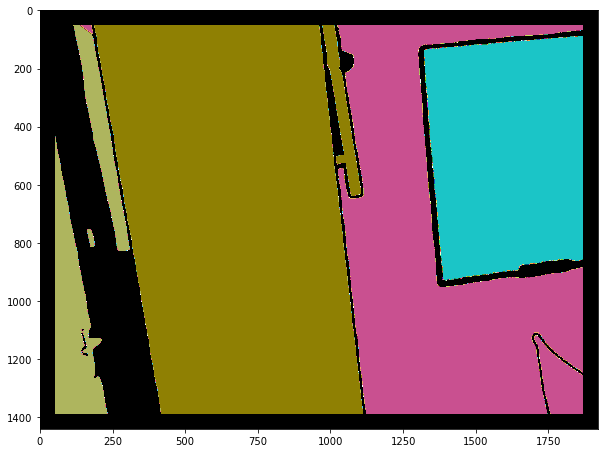

depthCheck [-0.41312221 -0.39866936 -0.27791597 ... -0.0203315  -0.02189901
 -0.0133721 ]
The Found Projection instance 11
Mapping {-100: -100, 3: 18, 6: 0, 7: 171, 11: 3889, 18: 0, 46: 2, 53: 147, 56: 0, 59: 0, 62: 0, 64: 28, 65: 0, 70: 0}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 6: 0, 7: 2527, 11: 148, 18: 3, 46: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 70, 65: 1, 70: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 6: 0, 7: 0, 11: 339, 18: 0, 46: 0, 53: 2891, 56: 1, 59: 3, 62: 1, 64: 0, 65: 0, 70: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 142, 7: 0, 11: 155, 18: 1, 46: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0, 70: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 3: 0, 6: 175, 7: 0, 11: 0, 18: 0, 46: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0, 70: 1}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 0, 7: 1, 11: 41, 18: 0, 46: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 

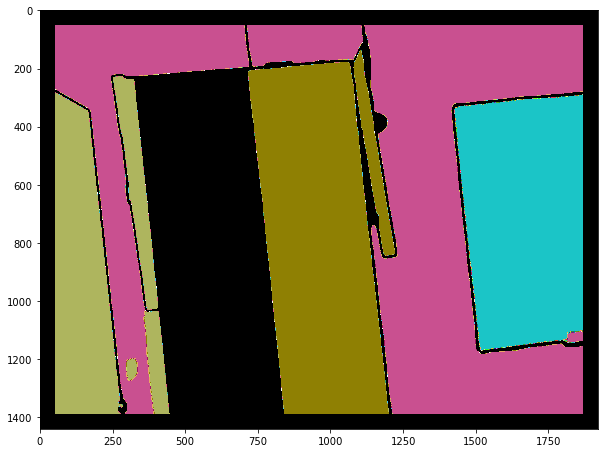

depthCheck [-0.26894572 -0.34294577 -0.28572235 ... -0.03154335 -0.02733991
 -0.02942038]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 6: 0, 7: 125, 11: 3474, 18: 0, 53: 173, 56: 1, 59: 0, 62: 0, 64: 28, 65: 0, 69: 223, 70: 0, 76: 7, 77: 73, 80: 11, 101: 2, 239: 1}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 6: 14, 7: 3574, 11: 251, 18: 139, 53: 0, 56: 0, 59: 0, 62: 0, 64: 61, 65: 5, 69: 0, 70: 0, 76: 0, 77: 0, 80: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 3: 2, 6: 0, 7: 0, 11: 290, 18: 0, 53: 2864, 56: 1, 59: 4, 62: 2, 64: 0, 65: 0, 69: 0, 70: 0, 76: 0, 77: 0, 80: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 3: 0, 6: 121, 7: 2, 11: 116, 18: 6, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0, 69: 0, 70: 0, 76: 0, 77: 0, 80: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 3: 0, 6: 206, 7: 0, 11: 0, 18: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 

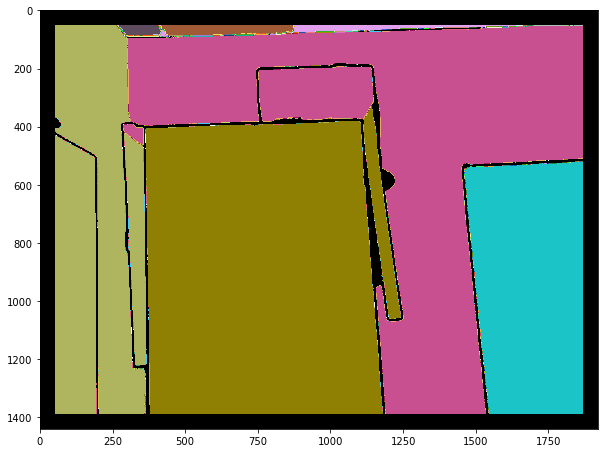

depthCheck [-0.95256273 -0.30720275 -0.31672012 ... -0.09322903 -0.05811381
 -0.08753712]
The Found Projection instance 11
Mapping {-100: -100, 6: 3, 7: 85, 11: 3437, 18: 0, 53: 122, 56: 0, 59: 0, 62: 0, 64: 31, 65: 1, 69: 199, 70: 0, 76: 7, 77: 54, 80: 10, 81: 0, 87: 0, 89: 0, 101: 2, 239: 1}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 6: 36, 7: 3060, 11: 148, 18: 114, 53: 0, 56: 0, 59: 0, 62: 0, 64: 45, 65: 5, 69: 0, 70: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 69
Mapping {-100: -100, 6: 0, 7: 0, 11: 4, 18: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0, 69: 13, 70: 0, 76: 0, 77: 6, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 1}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 6: 0, 7: 0, 11: 141, 18: 0, 53: 2222, 56: 0, 59: 3, 62: 1, 64: 0, 65: 0, 69: 0, 70: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 6: 183, 7: 0, 11

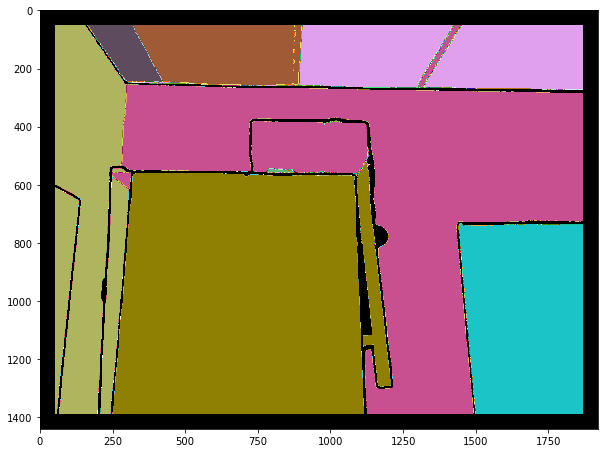

depthCheck [-0.97349171 -0.33236495 -0.34236453 ... -0.01663834 -0.02267194
 -0.02765296]
The Found Projection instance 11
Mapping {-100: -100, 6: 7, 7: 108, 11: 3841, 18: 0, 53: 141, 56: 0, 59: 0, 62: 0, 64: 32, 65: 0, 69: 166, 76: 6, 77: 47, 80: 10, 81: 0, 87: 0, 89: 0, 101: 2, 239: 1}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 6: 85, 7: 3241, 11: 120, 18: 106, 53: 0, 56: 0, 59: 0, 62: 0, 64: 28, 65: 4, 69: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 69
Mapping {-100: -100, 6: 0, 7: 0, 11: 15, 18: 0, 53: 0, 56: 0, 59: 0, 62: 0, 64: 0, 65: 0, 69: 17, 76: 2, 77: 10, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 6: 0, 7: 0, 11: 118, 18: 0, 53: 2374, 56: 0, 59: 4, 62: 2, 64: 0, 65: 0, 69: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 6
Mapping {-100: -100, 6: 234, 7: 0, 11: 81, 18: 0, 53: 0, 56: 0

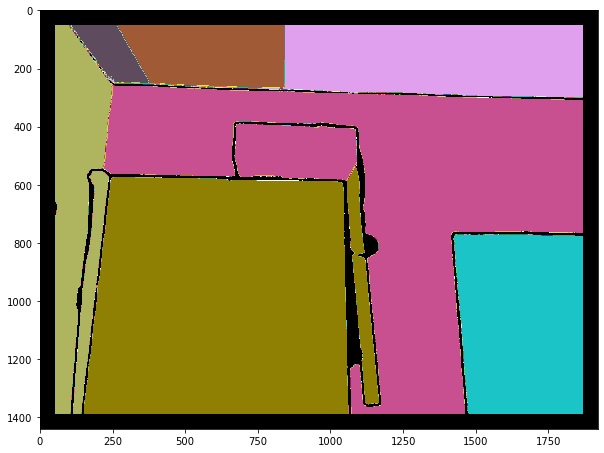

depthCheck [-9.61518704e-01 -3.74884850e-01 -3.65722868e-01 ...  6.74828906e-04
  2.63167295e-02  1.05274081e-02]
The Found Projection instance 11
Mapping {-100: -100, 6: 0, 7: 122, 11: 3568, 18: 0, 53: 128, 56: 0, 59: 0, 61: 0, 62: 0, 64: 32, 65: 0, 69: 5, 76: 0, 77: 1, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 6: 6, 7: 3356, 11: 104, 18: 76, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 38, 65: 5, 69: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 69
Mapping {-100: -100, 6: 0, 7: 0, 11: 44, 18: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 231, 76: 22, 77: 26, 80: 1, 81: 0, 87: 4, 89: 1, 101: 0, 239: 2}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 6: 0, 7: 0, 11: 124, 18: 0, 53: 3564, 56: 0, 59: 5, 61: 4, 62: 2, 64: 0, 65: 0, 69: 0, 76: 0, 77: 0, 80: 0, 81: 0, 87: 0, 89: 0, 101: 0, 239: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100

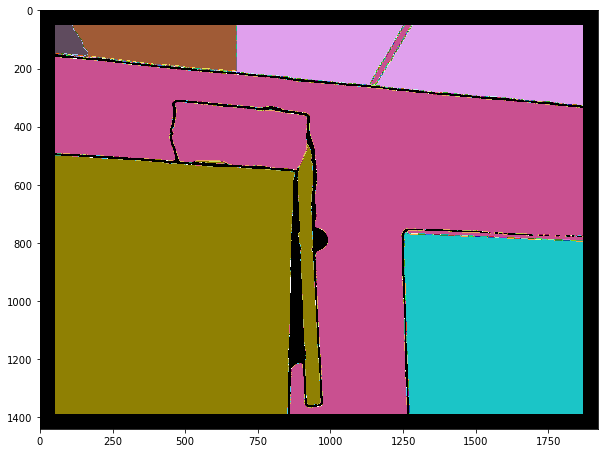

depthCheck [-0.39262141 -0.38961553 -0.38030067 ...  0.0365293   0.03485869
  0.03256045]
The Found Projection instance 11
Mapping {-100: -100, 7: 329, 11: 5346, 53: 109, 56: 0, 59: 0, 61: 0, 62: 0, 64: 40, 65: 0, 69: 326, 71: 1, 76: 7, 77: 52, 79: 0, 80: 3, 82: 0, 101: 2, 239: 2, 240: 1}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 7: 2533, 11: 18, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 40, 65: 2, 69: 0, 71: 0, 76: 0, 77: 0, 79: 0, 80: 0, 82: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 7: 0, 11: 268, 53: 5450, 56: 1, 59: 6, 61: 17, 62: 2, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 77: 0, 79: 0, 80: 0, 82: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 69
Mapping {-100: -100, 7: 0, 11: 5, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 205, 71: 0, 76: 5, 77: 87, 79: 0, 80: 0, 82: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 7: 8, 11: 195, 53: 0, 56: 0, 59: 0, 

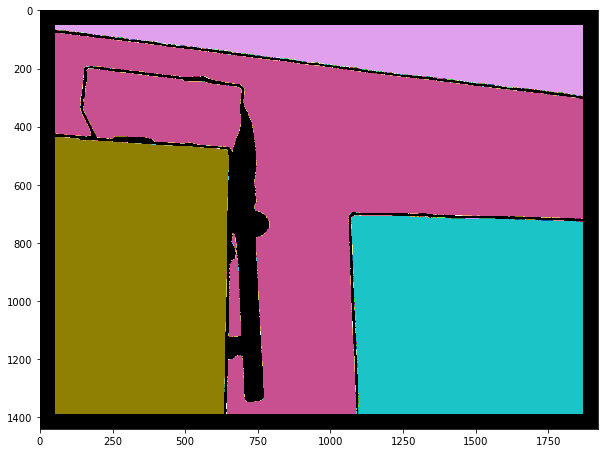

depthCheck [-0.50855526 -0.48348937 -0.50405463 ...  0.09162162  0.0951828
  0.11056849]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 558, 8: 0, 11: 6249, 47: 0, 51: 0, 53: 110, 56: 0, 59: 0, 61: 0, 62: 0, 64: 51, 65: 0, 69: 379, 71: 1, 76: 9, 90: 0, 101: 3, 239: 10, 240: 1}
MaxId 282
The Found Projection instance 53
Mapping {-100: -100, 3: 1, 7: 0, 8: 2, 11: 1084, 47: 30, 51: 1, 53: 7771, 56: 2, 59: 6, 61: 17, 62: 2, 64: 0, 65: 0, 69: 0, 71: 0, 76: 0, 90: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 1593, 8: 0, 11: 14, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 34, 65: 1, 69: 0, 71: 0, 76: 0, 90: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 69
Mapping {-100: -100, 3: 0, 7: 0, 8: 0, 11: 5, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 65: 0, 69: 47, 71: 0, 76: 1, 90: 0, 101: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 6, 8: 0,

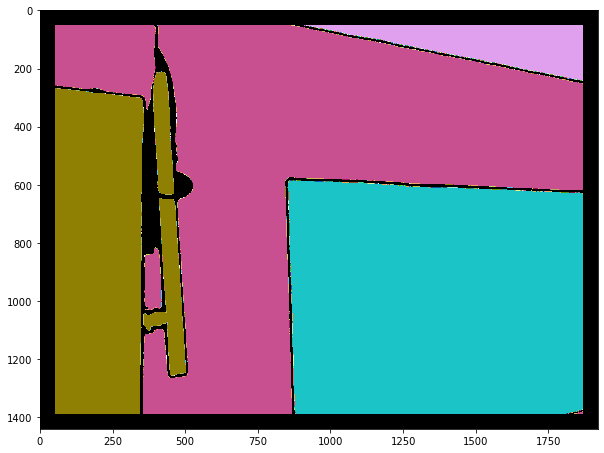

depthCheck [-0.53285978 -0.61141905 -0.82138459 ... -0.02525614 -0.00709488
 -0.05387212]
The Found Projection instance 53
Mapping {-100: -100, 3: 3, 7: 0, 8: 2, 11: 2182, 47: 34, 51: 1, 53: 8162, 56: 2, 59: 4, 61: 18, 62: 2, 64: 0, 69: 0, 71: 0, 76: 0, 78: 3, 88: 3, 96: 2, 98: 1, 100: 0, 101: 0, 106: 0, 115: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 247, 8: 0, 11: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 4, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 98: 0, 100: 0, 101: 0, 106: 0, 115: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 7
Mapping {-100: -100, 3: 0, 7: 286, 8: 0, 11: 47, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 21, 69: 0, 71: 0, 76: 0, 78: 0, 88: 0, 96: 0, 98: 0, 100: 0, 101: 0, 106: 0, 115: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 0, 8: 10, 11: 487, 47: 24, 51: 2, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 0, 71: 0, 76: 0, 78: 3, 88: 1

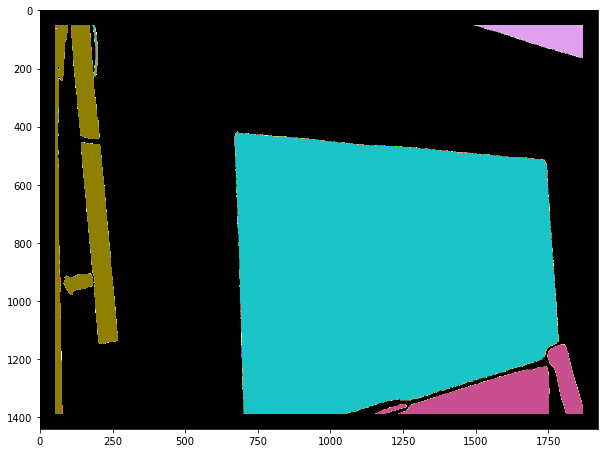

depthCheck [ 1.37281747 -0.72189584 -0.80144    ... -0.09366917 -0.08907258
 -0.09938597]
The Found Projection instance 11
Mapping {-100: -100, 3: 0, 7: 427, 8: 0, 11: 6195, 46: 0, 47: 0, 51: 0, 53: 81, 56: 0, 59: 0, 61: 0, 62: 0, 64: 5, 69: 118, 76: 8, 78: 1, 88: 0, 96: 62, 97: 13, 98: 0, 99: 5, 100: 1, 101: 2, 106: 3, 107: 0, 108: 0, 114: 0, 115: 0, 200: 1, 239: 14, 240: 42}
MaxId 282
The Found Projection instance 11
Mapping {-100: -100, 3: 16, 7: 0, 8: 36, 11: 1185, 46: 0, 47: 29, 51: 2, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 0, 76: 0, 78: 2, 88: 1, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 106: 0, 107: 0, 108: 0, 114: 0, 115: 1, 200: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection instance 96
Mapping {-100: -100, 3: 0, 7: 0, 8: 5, 11: 16, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 64: 0, 69: 0, 76: 0, 78: 0, 88: 0, 96: 18, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 106: 4, 107: 0, 108: 0, 114: 0, 115: 0, 200: 0, 239: 0, 240: 0}
MaxId 282
The Found Projection insta

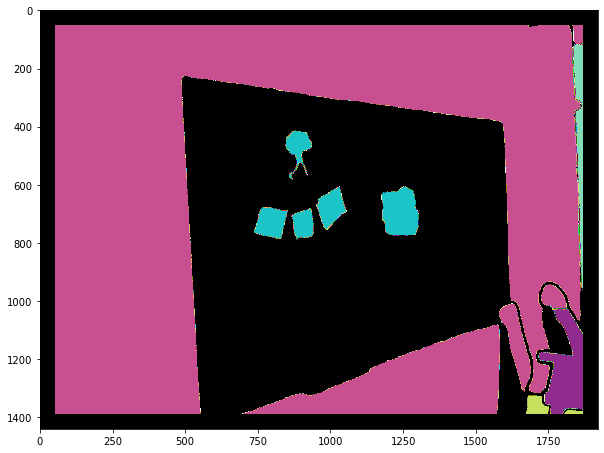

depthCheck [-0.85839828 -0.87220058 -0.71045151 ...  0.68687824  0.69776811
  0.62630461]
The Found Projection instance 11
Mapping {-100: -100, 0: 1, 3: 33, 7: 54, 8: 50, 11: 5800, 46: 1, 47: 15, 51: 2, 53: 95, 56: 0, 59: 0, 61: 0, 62: 0, 78: 3, 88: 1, 96: 55, 97: 184, 98: 1, 99: 3, 102: 1, 105: 0, 106: 7, 108: 1, 114: 0, 115: 3, 200: 2, 240: 19}
MaxId 282
The Found Projection instance 97
Mapping {-100: -100, 0: 0, 3: 0, 7: 0, 8: 0, 11: 33, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 167, 98: 0, 99: 0, 102: 0, 105: 13, 106: 0, 108: 24, 114: 0, 115: 0, 200: 22, 240: 0}
MaxId 282
CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 3: 0, 7: 0, 8: 0, 11: 0, 46: 0, 47: 0, 51: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 0, 98: 0, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 114: 0, 115: 0, 200: 0, 240: 0}
MaxId 283
The Found Projection instance 8
Mapping {-100: -100, 0: 0

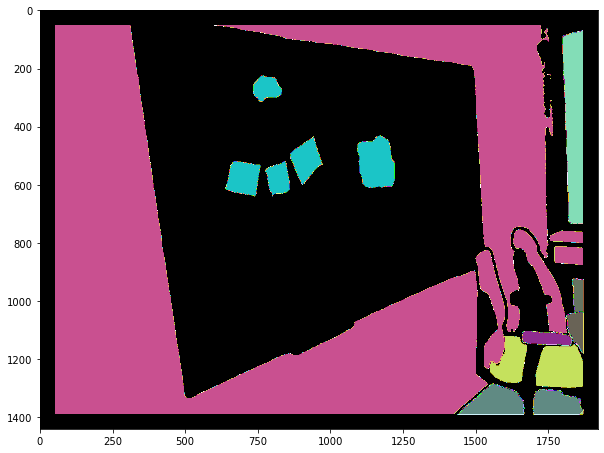

depthCheck [ 1.62629945  1.63603701  1.64294242 ... -1.02978799 -0.03040824
 -0.70538277]
The Found Projection instance 53
Mapping {-100: -100, 0: 0, 3: 5, 8: 1, 11: 1554, 46: 0, 47: 2, 53: 7649, 56: 1, 59: 5, 61: 39, 62: 2, 78: 1, 88: 2, 96: 8, 97: 0, 98: 1, 99: 0, 102: 0, 105: 0, 106: 0, 108: 0, 110: 0, 114: 0, 115: 0, 200: 0, 240: 0, 273: 0, 282: 0, 283: 0, 284: 0}
MaxId 287
The Found Projection instance 11
Mapping {-100: -100, 0: 0, 3: 0, 8: 0, 11: 396, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 29, 97: 288, 98: 1, 99: 3, 102: 0, 105: 0, 106: 6, 108: 0, 110: 0, 114: 0, 115: 0, 200: 0, 240: 2, 273: 0, 282: 0, 283: 0, 284: 0}
MaxId 287
The Found Projection instance 105
Mapping {-100: -100, 0: 0, 3: 0, 8: 0, 11: 105, 46: 0, 47: 0, 53: 0, 56: 0, 59: 0, 61: 0, 62: 0, 78: 0, 88: 0, 96: 0, 97: 140, 98: 0, 99: 0, 102: 0, 105: 182, 106: 0, 108: 86, 110: 0, 114: 0, 115: 0, 200: 8, 240: 0, 273: 0, 282: 0, 283: 0, 284: 0}
MaxId 287
The Found Projection instance 8
Mappin

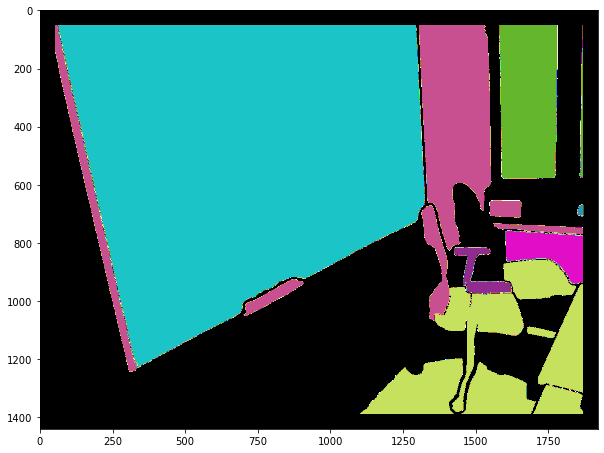

depthCheck [-0.95351526 -0.531281    1.54164287 ... -0.05560266 -0.22507955
  0.78986256]


KeyboardInterrupt: 

In [12]:
# main loop
samples=None
visu=vis.visualizerForIds()
max_id=0
howManyFrames=1000
for i in range(0,howManyFrames):
    currFramenumber=i*len(depth_paths)//howManyFrames
    color_data = cv2.imread(color_paths[currFramenumber])
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks, samples, max_id=createFrontMappingAutosort(currFramenumber, T_wc, K, depth_paths, mask_generator, max_id=max_id, smallesMaskSize=1000,current_frame=image, samples=samples,verbose=False)
    #print(i)
torch.cuda.empty_cache()

In [14]:
make_gif(f"/home/rozenberszki/D_Project/wsnsl/output/Own/")


[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F13321A1BD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1332595A10>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F13321CA610>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F133024E050>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE110>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE1D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE5D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE9D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE690>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F1250CBE150>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F120C55E190>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=720x720 at 0x7F120C55E4D0>, <PIL.PngImagePl